In [1]:
import os
import time
import pickle
import scipy
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
import torch
import torch.optim as optim

from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, TimeSeriesSplit, KFold, StratifiedKFold
from category_encoders import TargetEncoder, OneHotEncoder
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from math import sqrt
from datetime import datetime

In [2]:
from src.utils import check_stationarity, get_scaler, get_sample_weight, load_word2vec_embeddings, get_torch_optimizer, dummy_lagged_df, mase_loss, mean_absolute_scaled_error, compute_mase_scale, get_torch_criterion, get_confidence_interval, winkler_score
from src.arima import grid_search_arima
from src.sarimax import grid_search_sarimax
from src.ml_model import grid_search_ml, get_model, one_step_prediction as one_step_ml_prediction
from src.rnn import train_rnn, eval_rnn, one_step_prediction, grid_search_rnn, TimeSeriesDataset, ForecastModel

# Forecasting Visitor Arrivals
Precovid Sanity Test (Experiment 1)

## Baseline of simple SARIMA 

In [3]:
country_list = ['Canada', 'Chile', 'Mexico', 'Chinese Taipei', 'Hong Kong SAR', 'Japan', 
                'Korea (ROK)', 'Macao, China', 'Maldives', 'Cambodia', 'Indonesia', 'Singapore', 
                'New Zealand', 'USA', 'Thailand', 'Turkey', 'Australia', 'Hawaii', 'Austria', 'Czech']

imputed_dir = './data/imputed/'

In [4]:
aus_df = pd.read_csv(os.path.join(imputed_dir, 'Chile.csv'))
aus_df['Date'] = pd.to_datetime(aus_df['Date'])
aus_df = aus_df[aus_df['Date'] < '2020-01-01']
aus_df = aus_df.set_index('Date')

In [5]:
candidates = ['GDPPerCap', 'GDP', 'Population', 'FSI', 'FXAgainstChina', 'Temperature', 'Precipitation']
target = 'VisitorArrivals'

train_df = aus_df[[target] + candidates]
train_df = train_df.loc[train_df[target].first_valid_index(): train_df[target].last_valid_index()]
train_x, train_y = train_df[candidates], train_df[target]
# train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.2)
train_x, test_x, train_y, test_y = train_x.iloc[:-1*12], train_x.iloc[-1*12:], train_y.iloc[:-1*12], train_y.iloc[-1*12:]
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

In [6]:
len(test_y) / (len(train_y) + len(test_y))

0.125

In [7]:
test_y

Date
2019-01-01    3234.0
2019-02-01    3790.0
2019-03-01    4025.0
2019-04-01    3136.0
2019-05-01    2930.0
2019-06-01    2248.0
2019-07-01    2105.0
2019-08-01    2247.0
2019-09-01    2817.0
2019-10-01    2994.0
2019-11-01    2967.0
2019-12-01    3677.0
Name: VisitorArrivals, dtype: float64

/scratch/zt00296/Projects/tourism-forecasting/src/utils.py:46: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4)



The series isn't stationary


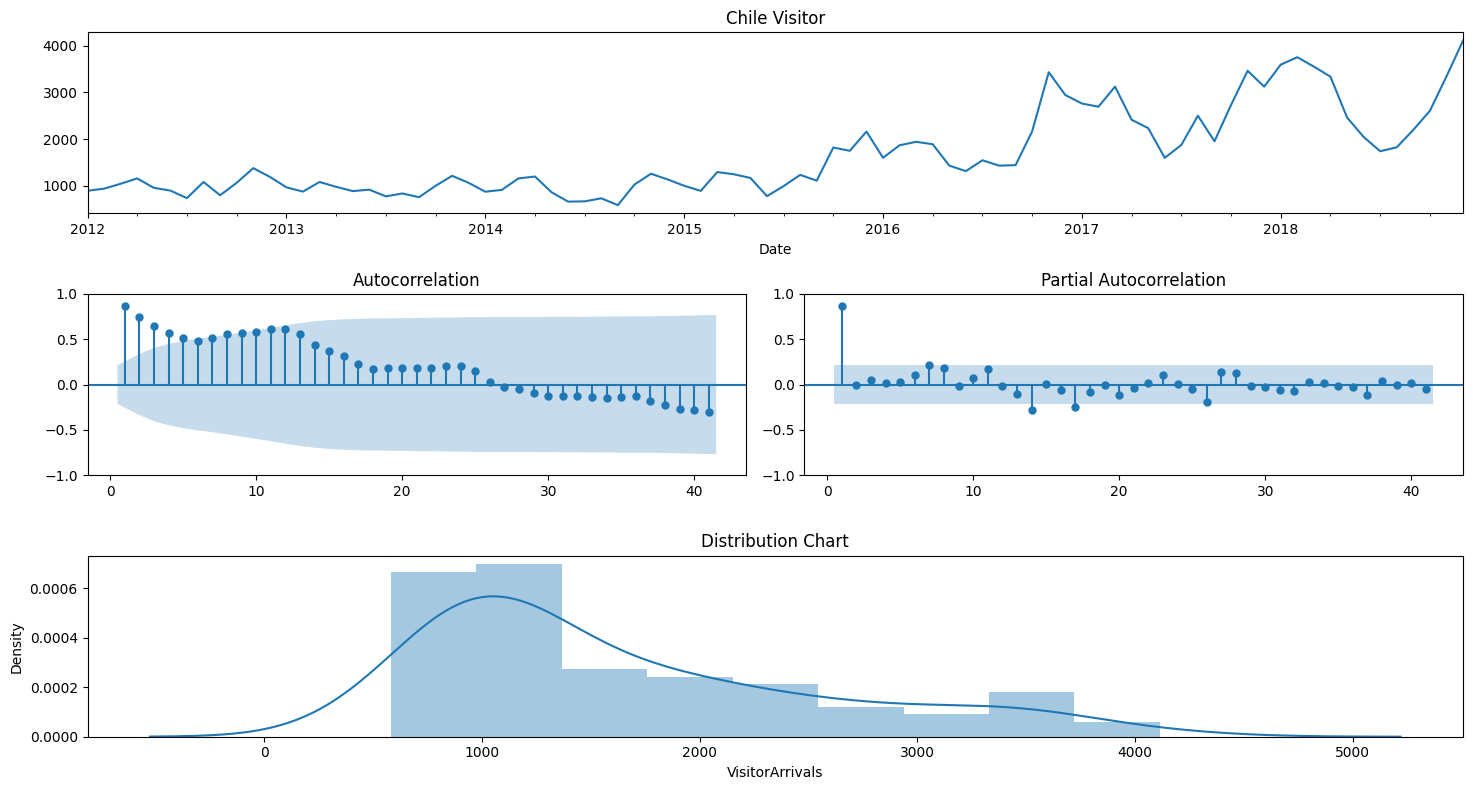

In [8]:
# find parameter analytically
check_stationarity(train_y.dropna(), title='Chile Visitor')

/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty sl

[(3, 0, 1), (1, 1, 1, 12), 'c'] 222.0778966407662


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


RMSE: 386.5509924753351
R2 0.5707250073628694


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: xlabel='Date'>

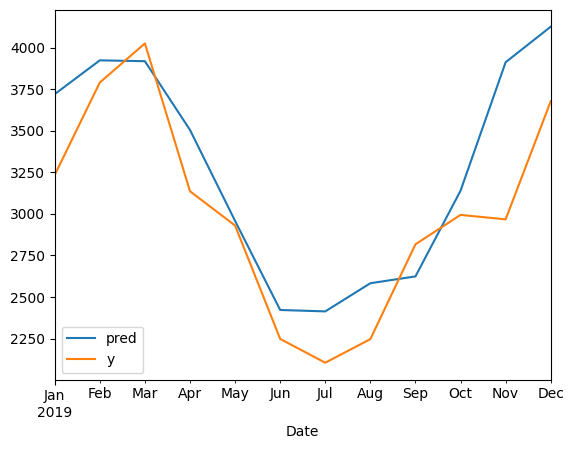

In [9]:
best_param, best_rmse, best_r2 = grid_search_sarimax(train_y, test_y, cv=True)
print(best_param, best_rmse)
sarima_model = sm.tsa.statespace.SARIMAX(train_y, order=best_param[0], seasonal_order=best_param[1], trend=best_param[2])
result = sarima_model.fit(disp=False)
pred = result.forecast(len(test_y))
print('RMSE:', sqrt(mean_squared_error(test_y, pred)))
print('R2', r2_score(test_y, pred))
pd.concat([pd.Series(pred, name='pred', index=test_y.index), pd.Series(test_y, name='y')], axis=1).plot()

In [10]:
sarima_pred, all_y, y_mase_scales = [], [], []
for c in country_list:
    f = c + '.csv'
    print('processing', f)
    df = pd.read_csv(os.path.join(imputed_dir, f))
    df['Date'] = pd.to_datetime(df['Date'])
    df = df[df['Date'] < '2020-01-01']
    df = df.set_index('Date')
    train_y = df[target]
    train_y = train_y.loc[train_y.first_valid_index(): train_y.last_valid_index()]
    for i in range(12, 0, -1):
        y_mase_scales.append(compute_mase_scale(train_y.iloc[:-i].values))
    train_y, test_y = train_y.iloc[:-1*12], train_y.iloc[-1*12:]
    best_param, best_rmse, best_r2 = grid_search_sarimax(train_y, test_y, cv=True, init_repeat=False)
    print(best_param, best_rmse, best_r2)
    sarima_model = sm.tsa.statespace.SARIMAX(train_y, order=best_param[0], seasonal_order=best_param[1], trend=best_param[2])
    result = sarima_model.fit(disp=False)
    pred = result.forecast(len(test_y))
    sarima_pred.append(pred)
    all_y.append(test_y)
sarima_pred, all_y = pd.concat(sarima_pred).values, pd.concat(all_y).values
y_mase_scales = np.asarray(y_mase_scales)

processing Canada.csv


/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty sl

[(2, 0, 1), (1, 0, 1, 12), 'n'] 3826.7434952984636 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


processing Chile.csv


/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty sl

[(3, 0, 1), (1, 1, 1, 12), 'c'] 222.0778966407662 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


processing Mexico.csv


/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty sl

[(3, 0, 1), (1, 0, 1, 12), 'c'] 1328.087132324264 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


processing Chinese Taipei.csv
[(1, 0, 0), (0, 0, 0, 12), 'c'] 48600.04210384344 None
processing Hong Kong SAR.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


[(1, 0, 0), (0, 1, 1, 12), 'n'] 620351.6216687443 None
processing Japan.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


[(3, 1, 1), (1, 1, 0, 12), 'n'] 64082.61819999945 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


processing Korea (ROK).csv
[(3, 0, 1), (1, 1, 1, 12), 'n'] 112466.80960032636 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


processing Macao, China.csv
[(3, 0, 1), (0, 1, 1, 12), 'c'] 145050.2880355367 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


processing Maldives.csv


/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty sl

[(2, 0, 1), (1, 0, 0, 12), 'c'] 2135.6353667821645 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/scratch/zt

processing Cambodia.csv


/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty sl

[(1, 0, 1), (1, 0, 0, 12), 'n'] 8926.931088850528 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/scra

processing Indonesia.csv
[(2, 1, 1), (1, 1, 1, 12), 'n'] 27591.206389474246 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


processing New Zealand.csv


/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty sl

[(2, 0, 0), (1, 0, 1, 12), 'n'] 3028.243313058678 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


processing USA.csv
[(3, 0, 1), (1, 1, 1, 12), 'n'] 23864.209598652174 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


processing Thailand.csv
[(3, 0, 1), (1, 1, 1, 12), 'n'] 118227.04999892694 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


processing Turkey.csv


/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty sl

[(3, 1, 1), (0, 0, 0, 12), 'c'] 5113.065125016372 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


processing Australia.csv


/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)


[(2, 0, 0), (1, 0, 1, 12), 'n'] 9359.174841198283 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


processing Hawaii.csv


/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty sl

[(3, 0, 1), (0, 0, 1, 12), 'n'] 1846.21913602951 None
processing Austria.csv


/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty sl

[(1, 0, 1), (0, 1, 1, 12), 'c'] 5456.119282166938 None
processing Czech.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)
/scratch/zt00296/Projects/tourism-forecasting/src/sarimax.py:92: RuntimeWarning: Mean of empty slice
  score = np.nanmean(score)


[(3, 0, 1), (0, 1, 1, 12), 'c'] 8654.86865123542 None


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


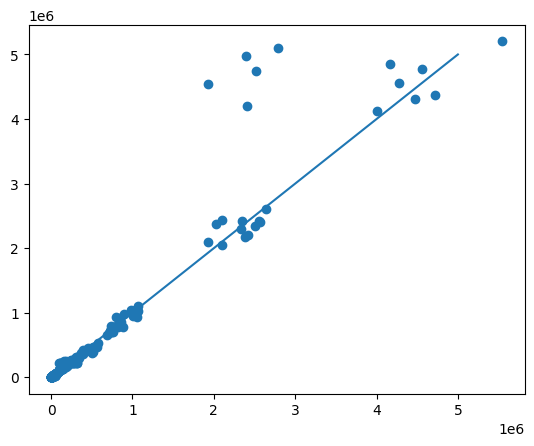

In [11]:
plt.scatter(all_y, sarima_pred)
plt.plot((0, 5000000), (0, 5000000))

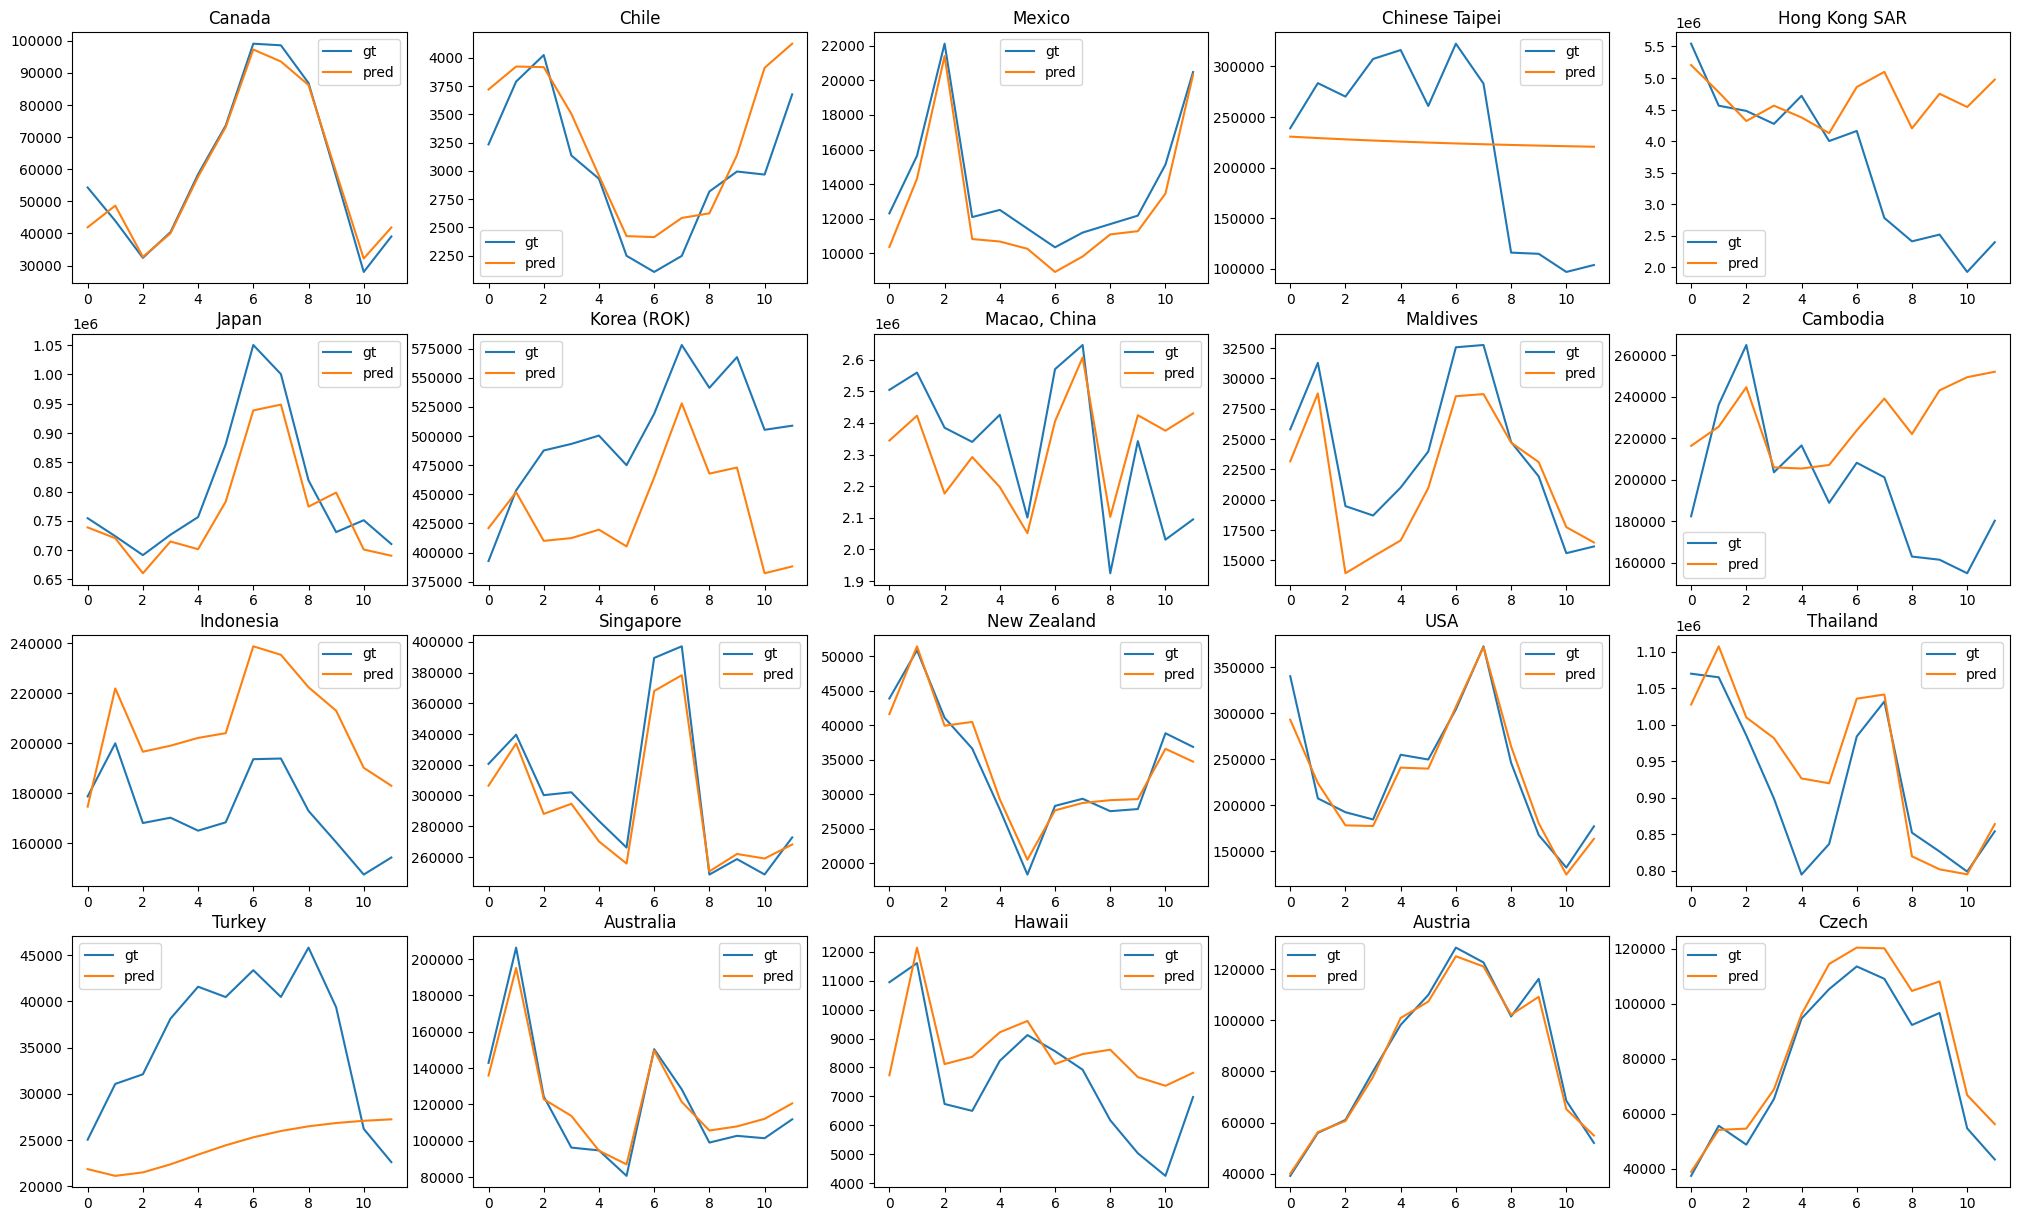

In [12]:
plt.figure(figsize=(25, 15))
for i, country in enumerate(country_list):
    plt.subplot(4, 5, i+1)
    plt.plot(all_y[i*12:i*12+12], label='gt')
    plt.plot(sarima_pred[i*12:i*12+12], label='pred')
    plt.legend()
    plt.title(country)
plt.show()

In [13]:
baseline_rmse = sqrt(mean_squared_error(all_y, sarima_pred))
baseline_r2 = r2_score(all_y, sarima_pred)
baseline_mae = mean_absolute_error(all_y, sarima_pred)
baseline_mape = mean_absolute_percentage_error(all_y, sarima_pred)
baseline_mase = mean_absolute_scaled_error(all_y, sarima_pred, y_mase_scales)
print(f'Baseline SARIMA RMSE: {baseline_rmse:.5f}\nBaseline SARIMA R2: {baseline_r2:.5f}'
      f'\nBaseline SARIMA MAE: {baseline_mae:.5f}\nBaseline SARIMA MAPE: {baseline_mape:.5f}\nBaseline SARIMA MASE: {baseline_mase:.5f}')

Baseline SARIMA RMSE: 345304.92988
Baseline SARIMA R2: 0.86231
Baseline SARIMA MAE: 84056.41925
Baseline SARIMA MAPE: 0.14748
Baseline SARIMA MASE: 1.40623


# Preprocessing Data

In [14]:
target = 'VisitorArrivals'
candidates = ['FXAgainstChina', 'CovidCases', 'CovidDeaths', 'FSI',
               'GDPPerCap', 'GDP', 'Population',
               'TravelPolicy', 'Temperature', 'Precipitation', 'GlobalCovidTrend',
               'DistFromChina', 'Country', 'GDPRatioChina',
               'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina',
               'ChinaConfinementPolicy', 'ChinaMovementPolicy', 'ChinaGDPPerCap',
               'ChinaGDP']
def load_data(country='Japan', csv_dir='./data/imputed', log_transform=True, dropna=True, remove_covid=False):
    df = pd.read_csv(os.path.join(csv_dir, f'{country}.csv'))
    if dropna:
        df = df.iloc[df['VisitorArrivals'].first_valid_index():].reset_index(drop=True)
    if log_transform:
        df['VisitorArrivals'] = np.log1p(df['VisitorArrivals'])
    df['Date'] = pd.to_datetime(df['Date'])
    if remove_covid:
        # df = df[df['Date'] < ('2019-07-01' if country in ['Hong Kong SAR', 'Chinese Taipei'] else '2020-01-01')]
        df = df[df['Date'] < '2020-01-01']
    df = df.set_index('Date').asfreq('MS')
    return df[candidates + [target]]

In [15]:
df = load_data()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 331 entries, 1997-01-01 to 2024-07-01
Freq: MS
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   FXAgainstChina            331 non-null    float64
 1   CovidCases                319 non-null    float64
 2   CovidDeaths               319 non-null    float64
 3   FSI                       331 non-null    float64
 4   GDPPerCap                 331 non-null    float64
 5   GDP                       331 non-null    float64
 6   Population                331 non-null    float64
 7   TravelPolicy              331 non-null    float64
 8   Temperature               331 non-null    float64
 9   Precipitation             331 non-null    float64
 10  GlobalCovidTrend          331 non-null    float64
 11  DistFromChina             331 non-null    float64
 12  Country                   331 non-null    object 
 13  GDPRatioChina             331 non-nul

Text(0.5, 0, 'Tourism Arrivals')

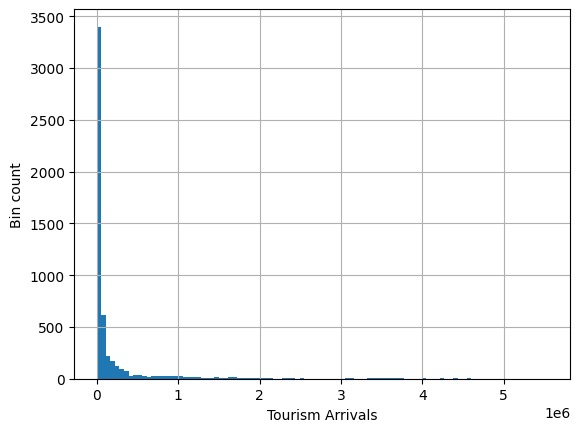

In [16]:
pd.concat([load_data(country, log_transform=False)['VisitorArrivals'] for country in country_list], ignore_index=True).hist(bins=100)
plt.ylabel('Bin count')
plt.xlabel('Tourism Arrivals')

Text(0.5, 0, 'Log-transformed & standardised Tourism Arrivals')

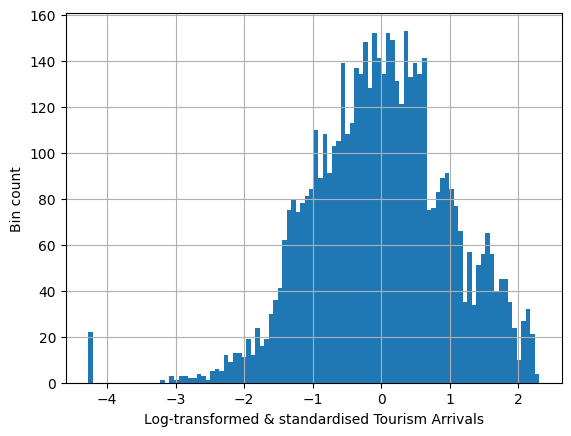

In [17]:
temp = pd.concat([load_data(country, log_transform=True)['VisitorArrivals'] for country in country_list], ignore_index=True)
temp = (temp - temp.mean() )/ temp.std()
temp.hist(bins=100)
plt.ylabel('Bin count')
plt.xlabel('Log-transformed & standardised Tourism Arrivals')

In [18]:
df['VisitorArrivals'] = (df['VisitorArrivals'] - df['VisitorArrivals'].mean()) / df['VisitorArrivals'].std()

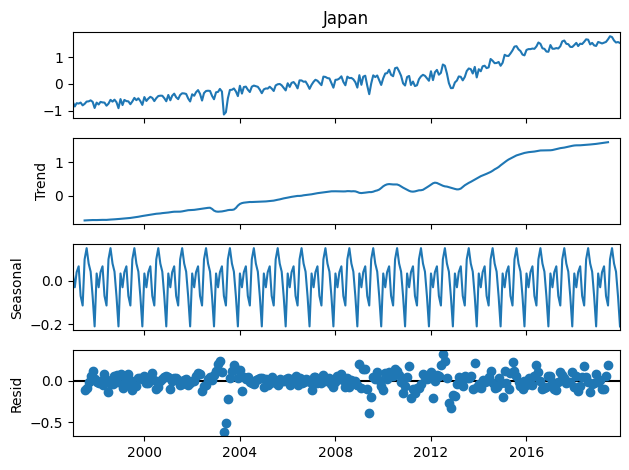

In [19]:
res = seasonal_decompose(df[df.index < '2020-01-01']['VisitorArrivals'].rename('Japan'), period=12)
fig = res.plot()
# plt.suptitle('Japan')

<Axes: xlabel='Date'>

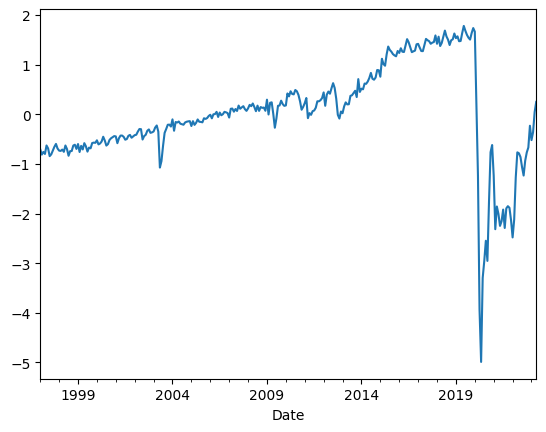

In [20]:
seasonal_component = pd.concat([res.seasonal, pd.Series(np.resize(res.seasonal.values[-12:], len(df['VisitorArrivals'].dropna()) - len(res.seasonal)))], ignore_index=True)
seasonal_component.index = df['VisitorArrivals'].dropna().index
(df['VisitorArrivals'].dropna() - seasonal_component).plot()

Text(0, 0.5, 'Processed Tourism Arrivals')

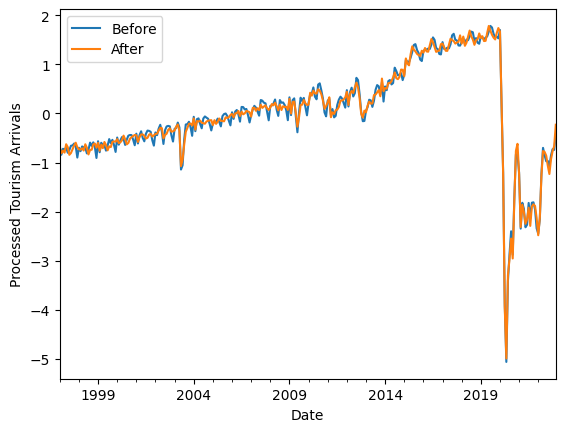

In [21]:
df['Before'] = df['VisitorArrivals']
df['After'] = (df['VisitorArrivals'].dropna() - seasonal_component)
df[df.index < '2023-01-01'][['Before', 'After']].plot()
plt.ylabel('Processed Tourism Arrivals')

In [22]:
from src.utils import get_seasonal_component, inverse_target
#load all data and decomposed precovid seasonality
def load_and_preprocess_all(test_size=0, deduct_seasonality=True, single_x_scaler=False, single_y_scaler=False, scaler_type='standard', remove_covid=False):
    all_data = {country: load_data(country, remove_covid=remove_covid) for country in country_list}
    all_decomposed_seasonal = {country: seasonal_decompose(df[df.index < '2020-01-01']['VisitorArrivals'], period=12) for country, df in all_data.items()}
    
    x_scaler, y_scaler = {}, {}
    #some feature engineering and processing
    for country in country_list:
        all_data[country]['Popularity'] = all_data[country]['VisitorArrivals'].median()
        all_data[country]['Unrest'] = 0.
        all_data[country]['TravelRestriction'] = (all_data[country][['TravelPolicy', 'ChinaConfinementPolicy', 'ChinaMovementPolicy']] > 0).all(axis=1).astype(int)
        
        all_data[country]['Year'] = all_data[country].index.year
        all_data[country]['MonthSin'] = np.sin(2 * np.pi * (all_data[country].index.month - 1) / 12.0)
        all_data[country]['MonthCos'] = np.cos(2 * np.pi * (all_data[country].index.month - 1) / 12.0)
        
        if deduct_seasonality:
            # remove seasonality
            seasonal_component = get_seasonal_component(all_decomposed_seasonal[country], len(all_data[country]))
            assert len(seasonal_component) == len(all_data[country])
            seasonal_component.index = all_data[country].index
            all_data[country]['VisitorArrivals'] -= seasonal_component
            
        # 1. taiwan ban china starting september 2019 - january 2024 election
        # 2. hong kong protest starting august 2019 end mid 2020
        # 3. china ban korea starting march 2017 - nov 2017
        # 4. singapore and thailand april 2014 - jan 2015
        # 5. sars world april 2003 - july 2003
        # 6. hawaii and USA trump presidential between november 2016 to january 2021
        # 7. turkey coup 2016
        if country == 'Chinese Taipei':
            all_data[country].loc[(all_data[country].index >= '2019-09-01') & (all_data[country].index <= '2024-02-01'), 'TravelRestriction'] = 1
        elif country == 'Hong Kong SAR':
            all_data[country].loc[(all_data[country].index >= '2019-08-01') & (all_data[country].index <= '2020-06-01'), 'Unrest'] = 1.
        elif country == 'Korea (ROK)':
            all_data[country].loc[(all_data[country].index >= '2017-03-01') & (all_data[country].index <= '2017-11-01'), 'TravelRestriction'] = 1
        elif country in ['Singapore', 'Thailand']:
            all_data[country].loc[(all_data[country].index >= '2014-04-01') & (all_data[country].index <= '2015-01-01'), 'Unrest'] = 1.
        elif country in ['Hawaii', 'USA']:
            all_data[country].loc[(all_data[country].index >= '2016-11-01') & (all_data[country].index <= '2021-01-01'), 'Unrest'] = 0.5
        elif country == 'Turkey':
            all_data[country].loc[(all_data[country].index >= '2015-12-01') & (all_data[country].index <= '2017-02-01'), 'Unrest'] = 1.
            
        all_data[country].loc[(all_data[country].index >= '2003-04-01') & (all_data[country].index <= '2003-07-01'), 'Unrest'] = 1. # SARS

        # assume covid case and deaths exponentially reduce
        for c in ['CovidCases', 'CovidDeaths']:
            all_data[country][c] = all_data[country][c].fillna(all_data[country][c].ffill()[all_data[country][c].isnull()].mul((1/2)**(all_data[country][c].groupby(all_data[country][c].notnull().cumsum()).cumcount()), 0)).round()
    
    country_feat = ['GDPPerCap', 'GDP', 'Population', 'CovidCases', 'CovidDeaths', 
                    'Temperature', 'Precipitation',]  # only normalize country specific features, other features are universal which will be normalize separately
    if single_x_scaler:
        temp_df = pd.concat([all_data[country][country_feat].iloc[:all_data[country][target].notna().sum()-test_size] for country in country_list], ignore_index=True)  # only fit on train that is valid
        x_scaler = get_scaler(scaler_type)
        x_scaler.fit(temp_df)
        for country in country_list:
            all_data[country][country_feat] = x_scaler.transform(all_data[country][country_feat])
    else:
        for country in country_list:
            country_x_scaler = get_scaler(scaler_type)
            country_x_scaler.fit(all_data[country][country_feat].iloc[:all_data[country][target].notna().sum()-test_size])
            all_data[country][country_feat] = country_x_scaler.transform(all_data[country][country_feat])
            x_scaler[country] = country_x_scaler
    
    universal_feat = ['FXAgainstChina', 'FSI', 'Year', 'MonthSin', 'MonthCos', 'Unrest',
                       'TravelPolicy', 'GlobalCovidTrend',
                       'DistFromChina', 'GDPRatioChina',
                       'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina',
                       'ChinaConfinementPolicy', 'ChinaMovementPolicy', 'ChinaGDPPerCap',
                       'ChinaGDP', 'Popularity', 'TravelRestriction']
    universal_x_scaler = get_scaler(scaler_type)
    temp_df = pd.concat([all_data[country][universal_feat].iloc[:all_data[country][target].notna().sum()-test_size] for country in country_list], ignore_index=True)
    universal_x_scaler.fit(temp_df)
    for country in country_list:
        all_data[country][universal_feat] = universal_x_scaler.transform(all_data[country][universal_feat])
        
    if single_y_scaler:
        temp_df = pd.concat([all_data[country][[target]].iloc[:all_data[country][target].notna().sum()-test_size] for country in country_list], ignore_index=True) # only fit on train
        y_scaler = get_scaler(scaler_type)
        y_scaler.fit(temp_df)
        for country in country_list:
            all_data[country][[target]] = y_scaler.transform(all_data[country][[target]])
    else:
        for country in country_list:
            country_y_scaler = get_scaler(scaler_type)
            country_y_scaler.fit(all_data[country][[target]].iloc[:all_data[country][target].notna().sum()-test_size])
            all_data[country][[target]] = country_y_scaler.transform(all_data[country][[target]])
            y_scaler[country] = country_y_scaler
    
    return all_data, all_decomposed_seasonal, x_scaler, universal_x_scaler, y_scaler

In [23]:
deduct_seasonality = True
single_x_scaler = False
single_y_scaler = False
all_data, all_decomposed_seasonal, x_scaler, universal_x_scaler, y_scaler = load_and_preprocess_all(test_size=12, deduct_seasonality=deduct_seasonality, single_x_scaler=single_x_scaler, single_y_scaler=single_y_scaler, remove_covid=True)

<Axes: xlabel='Date'>

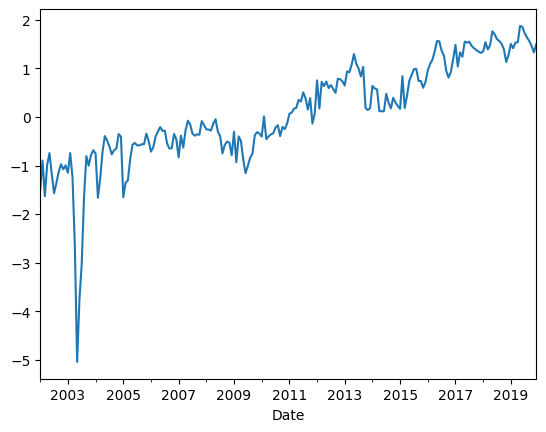

In [24]:
country = 'Singapore'
all_data[country]['VisitorArrivals'].plot()

In [25]:
all_data[country]

FXAgainstChina  CovidCases  CovidDeaths       FSI  GDPPerCap  \
Date                                                                       
2002-01-01       -0.258922         0.0          0.0 -0.701804  -1.933853   
2002-02-01       -0.258925         0.0          0.0 -0.701804  -1.910476   
2002-03-01       -0.258927         0.0          0.0 -0.701804  -1.887099   
2002-04-01       -0.258927         0.0          0.0 -0.701804  -1.863722   
2002-05-01       -0.258939         0.0          0.0 -0.701804  -1.840345   
...                    ...         ...          ...       ...        ...   
2019-08-01       -0.259016         0.0          0.0 -1.024345   1.426329   
2019-09-01       -0.259024         0.0          0.0 -1.024345   1.400218   
2019-10-01       -0.259026         0.0          0.0 -1.024345   1.374108   
2019-11-01       -0.259023         0.0          0.0 -1.024345   1.347998   
2019-12-01       -0.259025         0.0          0.0 -1.024345   1.321888   

                 GDP  Population  TravelPolicy  Temperature  Precipitation  \
Date                                                                         
2002-01-01 -1.681899   -1.598512           0.0    -0.877961      -0.362024   
2002-02-01 -1.669684   -1.594969           0.0    -0.050308      -1.490460   
2002-03-01 -1.657470   -1.591424           0.0     1.108406      -0.913265   
2002-04-01 -1.645255   -1.587880           0.0     1.439467      -0.329842   
2002-05-01 -1.633041   -1.584336           0.0     1.936058      -0.115989   
...              ...         ...           ...          ...            ...   
2019-08-01  1.490276    1.360326           0.0     0.942875      -1.415715   
2019-09-01  1.476286    1.366896           0.0     0.611814      -1.567281   
2019-10-01  1.462296    1.373464           0.0    -0.050308      -0.212535   
2019-11-01  1.448305    1.380032           0.0    -0.215839      -0.373443   
2019-12-01  1.434315    1.386601           0.0    -1.209022       1.519049   

            ...  ChinaMovementPolicy  ChinaGDPPerCap  ChinaGDP  \
Date        ...                                                  
2002-01-01  ...                  0.0       -1.130280 -1.120209   
2002-02-01  ...                  0.0       -1.122633 -1.112892   
2002-03-01  ...                  0.0       -1.114986 -1.105576   
2002-04-01  ...                  0.0       -1.107339 -1.098259   
2002-05-01  ...                  0.0       -1.099693 -1.090943   
...         ...                  ...             ...       ...   
2019-08-01  ...                  0.0        1.826869  1.874271   
2019-09-01  ...                  0.0        1.833664  1.882189   
2019-10-01  ...                  0.0        1.840459  1.890107   
2019-11-01  ...                  0.0        1.847254  1.898025   
2019-12-01  ...                  0.0        1.854049  1.905942   

            VisitorArrivals  Popularity    Unrest  TravelRestriction  \
Date                                                                   
2002-01-01        -1.501527    0.659436 -0.180049          -0.045872   
2002-02-01        -0.896859    0.659436 -0.180049          -0.045872   
2002-03-01        -1.631448    0.659436 -0.180049          -0.045872   
2002-04-01        -0.986685    0.659436 -0.180049          -0.045872   
2002-05-01        -0.743344    0.659436 -0.180049          -0.045872   
...                     ...         ...       ...                ...   
2019-08-01         1.635874    0.659436 -0.180049          -0.045872   
2019-09-01         1.564336    0.659436 -0.180049          -0.045872   
2019-10-01         1.462316    0.659436 -0.180049          -0.045872   
2019-11-01         1.330468    0.659436 -0.180049          -0.045872   
2019-12-01         1.498101    0.659436 -0.180049          -0.045872   

                Year  MonthSin  MonthCos  
Date                                      
2002-01-01 -0.937811  0.002012  1.415325  
2002-02-01 -0.937811  0.709120  1.225856  
2002-03-01 -0.937811  1.226759  0.708218

## Regression

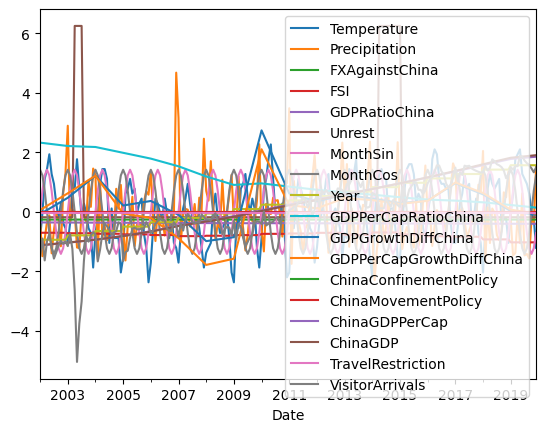

Pearson: 0.13168831000374417
Kendall: 0.12348292900969479
Spearman: 0.17840523824690488


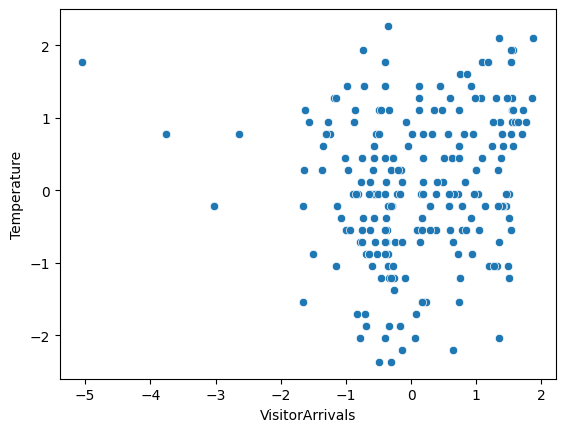

Pearson: -0.02526419132044302
Kendall: -0.02588787712048014
Spearman: -0.042343437374655235


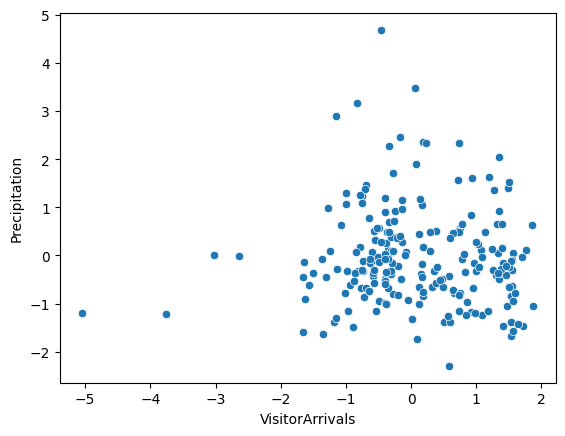

Pearson: -0.2171989918634032
Kendall: -0.16210163652024115
Spearman: -0.22529203729503802


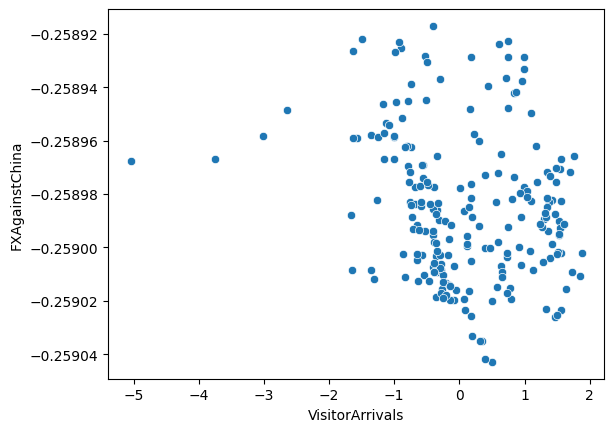

Pearson: -0.5662894024587972
Kendall: -0.3585607809190079
Spearman: -0.49757304559467425


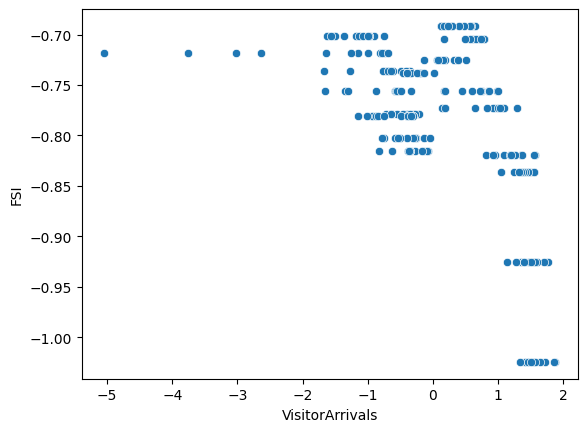

Pearson: -0.8539447518341834
Kendall: -0.7545219638242893
Spearman: -0.9217471034425272


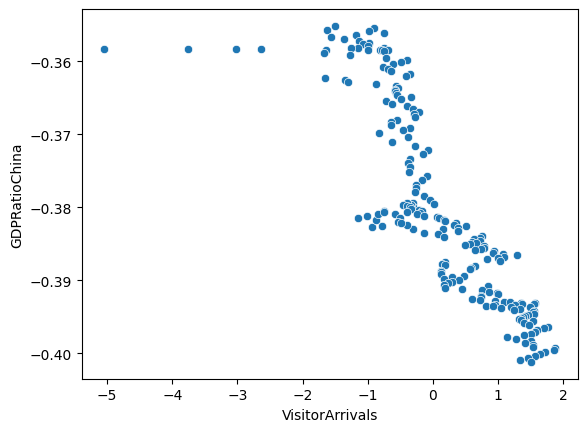

Pearson: -0.24095972309554325
Kendall: -0.06885942449248422
Spearman: -0.08414068180540754


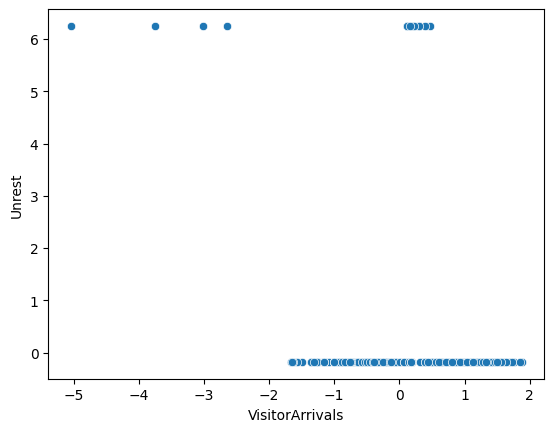

Pearson: -0.02712107113068919
Kendall: 0.011667005828742603
Spearman: 0.0181526851628306


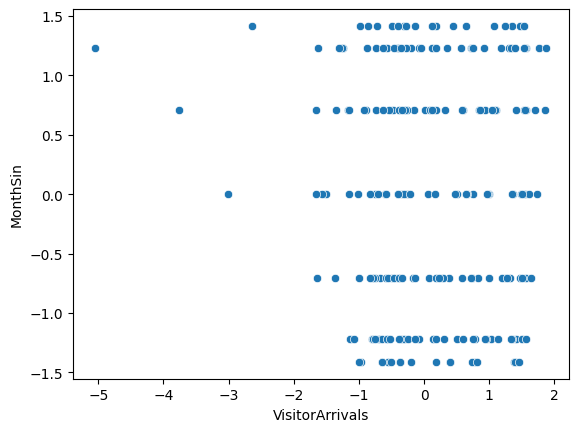

Pearson: -0.013873602451566963
Kendall: -0.03581499463707032
Spearman: -0.05048277903443573


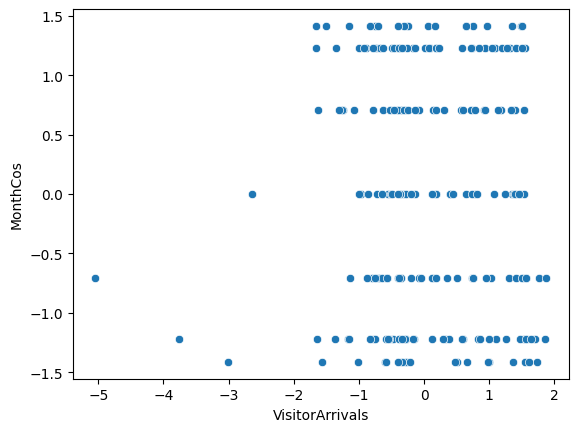

Pearson: 0.8837197173698117
Kendall: 0.7877726256985058
Spearman: 0.933307241384511


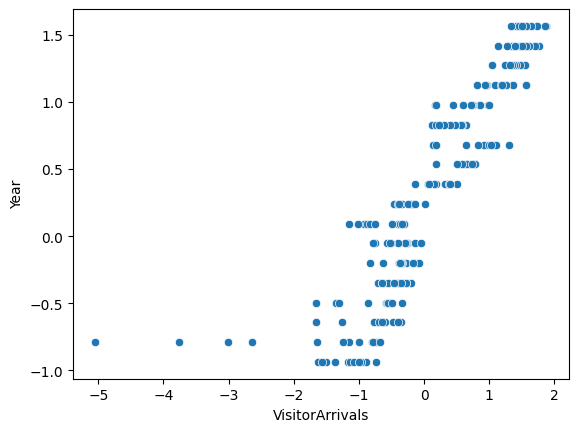

Pearson: -0.8397406847430227
Kendall: -0.7675279931093884
Spearman: -0.9310279950940115


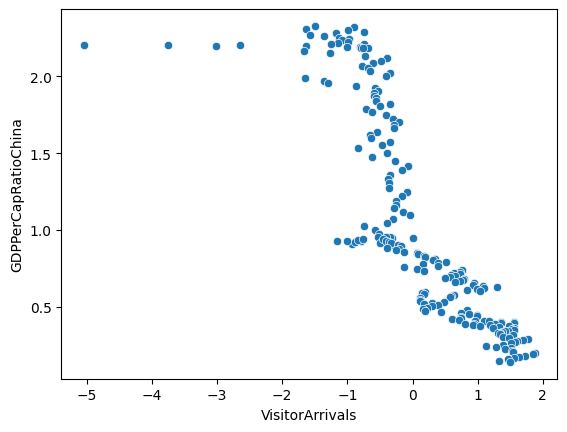

Pearson: -0.016179252434819314
Kendall: 0.04453057708871662
Spearman: 0.04770716488645971


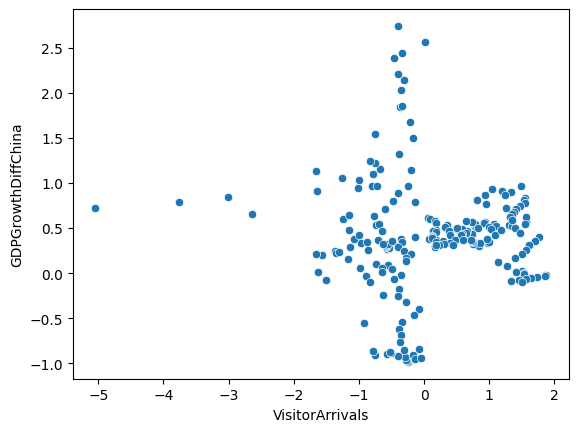

Pearson: 0.1104403635658284
Kendall: 0.10387596899224805
Spearman: 0.12904416580335556


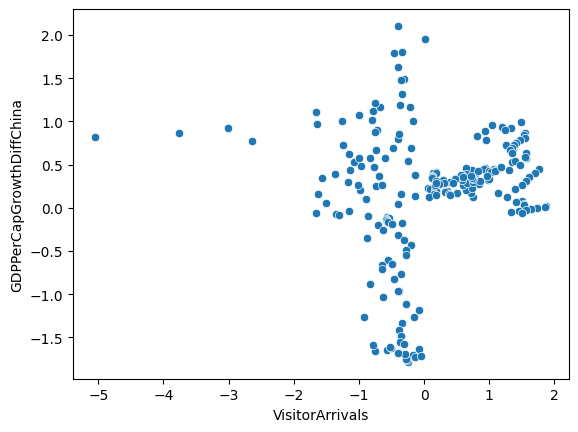

Pearson: nan
Kendall: nan
Spearman: nan


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


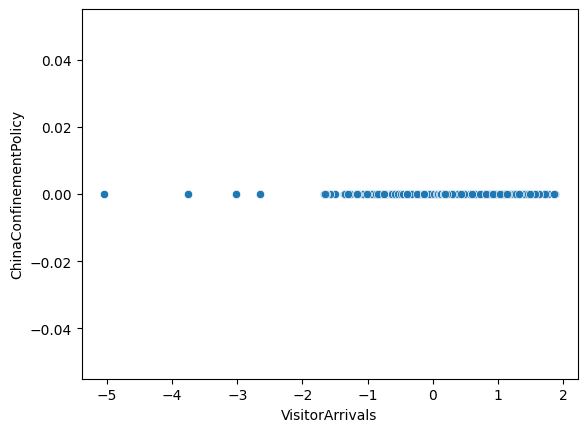

Pearson: nan
Kendall: nan
Spearman: nan


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


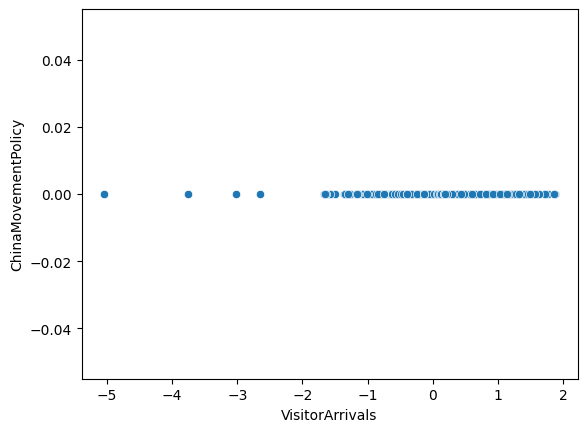

Pearson: 0.8835006063228443
Kendall: 0.7708871662360033
Spearman: 0.9334154967313255


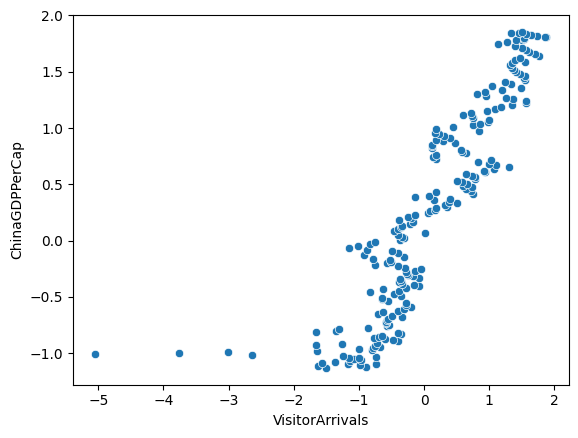

Pearson: 0.8829387153358655
Kendall: 0.7708871662360033
Spearman: 0.9334154967313255


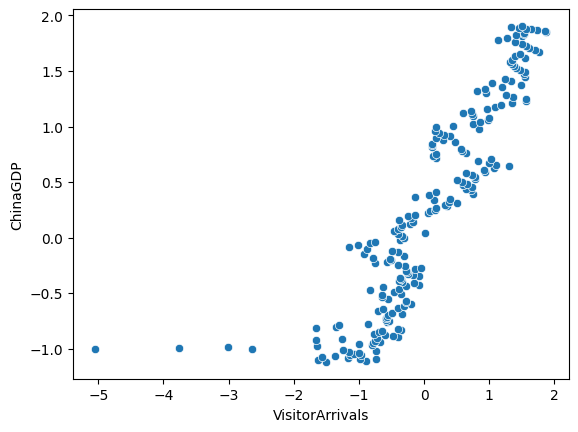

Pearson: nan
Kendall: nan
Spearman: nan


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


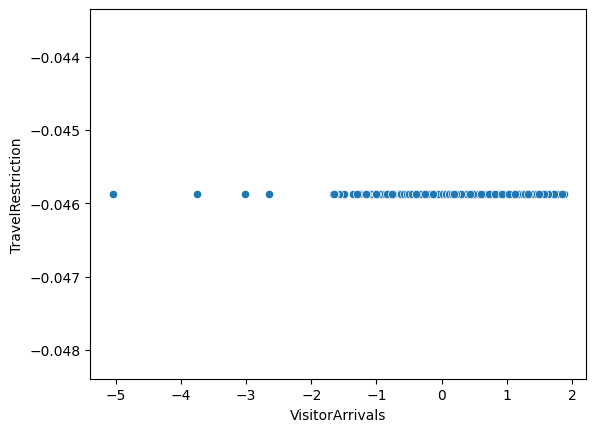

In [26]:
country_feat = [#'GDPPerCap', 'GDP', 'Population', 
                'Temperature', 'Precipitation',]
universal_feat = ['FXAgainstChina', 'FSI',
                   'GDPRatioChina', 'Unrest', 'MonthSin', 'MonthCos', 'Year',
                   'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina',
                   'ChinaConfinementPolicy', 'ChinaMovementPolicy', 'ChinaGDPPerCap',
                   'ChinaGDP', 'TravelRestriction']
target = 'VisitorArrivals'
all_data[country][country_feat + universal_feat + [target]].plot()
plt.show()
for candidate in country_feat + universal_feat:
    print('Pearson:', all_data[country][target].corr(all_data[country][candidate]))
    print('Kendall:', all_data[country][target].corr(all_data[country][candidate], method='kendall'))
    print('Spearman:', all_data[country][target].corr(all_data[country][candidate], method='spearman'))
    sns.scatterplot(all_data[country], x=target, y=candidate)
    plt.show()

In [27]:
# repeat for all countries
reg_pred, all_y = [], []
for country, df in all_data.items():
    print('processing', country)
    df = df.copy().dropna()
    train_x, train_y = df[country_feat + universal_feat], df[target]
    train_y, train_x, _ = dummy_lagged_df(train_y, train_x, lag=1)
    train_x, test_x, train_y, test_y = train_x.iloc[:-1*12], train_x.iloc[-1*12:], train_y.iloc[:-1*12], train_y.iloc[-1*12:]
    best_param, best_mae = grid_search_ml(train_x, train_y, score_function=mean_absolute_error, preprocess=['nopreprocess'],#sample_weight=sample_weight,
                                           additional_params={'rf': [{'n_estimators': n} for n in (3, 5, 10, 50, 100)],
                                                              'mlp': [{'hidden_layer_sizes': n} for n in (1, 2, 3, 5, 10)],
                                                              'xgb': [{'n_estimators': n} for n in (3, 5, 10, 50, 100)]})
    print(best_param, best_mae)
    model = get_model(best_param[0])
    model = model.set_params(**best_param[2])
    scaler = get_scaler(best_param[1])
    train_x_ = scaler.fit_transform(train_x)
    test_x_ = scaler.transform(test_x)
    model.fit(train_x_, train_y,)# sample_weight=sample_weight)
    pred = model.predict(test_x_)
    
    reg_pred.append(inverse_target(pred, all_decomposed_seasonal[country].seasonal.loc[test_y.index - pd.DateOffset(years=4)].values if deduct_seasonality else 0., 
                                   y_scaler if single_y_scaler else y_scaler[country]))
    all_y.append(inverse_target(test_y, all_decomposed_seasonal[country].seasonal.loc[test_y.index - pd.DateOffset(years=4)].values if deduct_seasonality else 0., 
                                y_scaler if single_y_scaler else y_scaler[country]))
    
reg_pred, all_y = np.concatenate(reg_pred), np.concatenate(all_y)

processing Canada
('rf', 'nopreprocess', {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}) 0.24738538586142983
processing Chile
('rf', 'nopreprocess', {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 3, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}) 0.25383179750119556
processing Mexico
('rf', 'nopreprocess', {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': Non

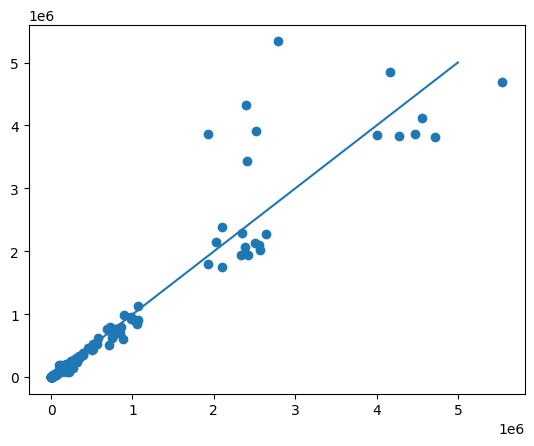

In [28]:
plt.scatter(all_y, reg_pred)
plt.plot((0, 5000000), (0, 5000000))

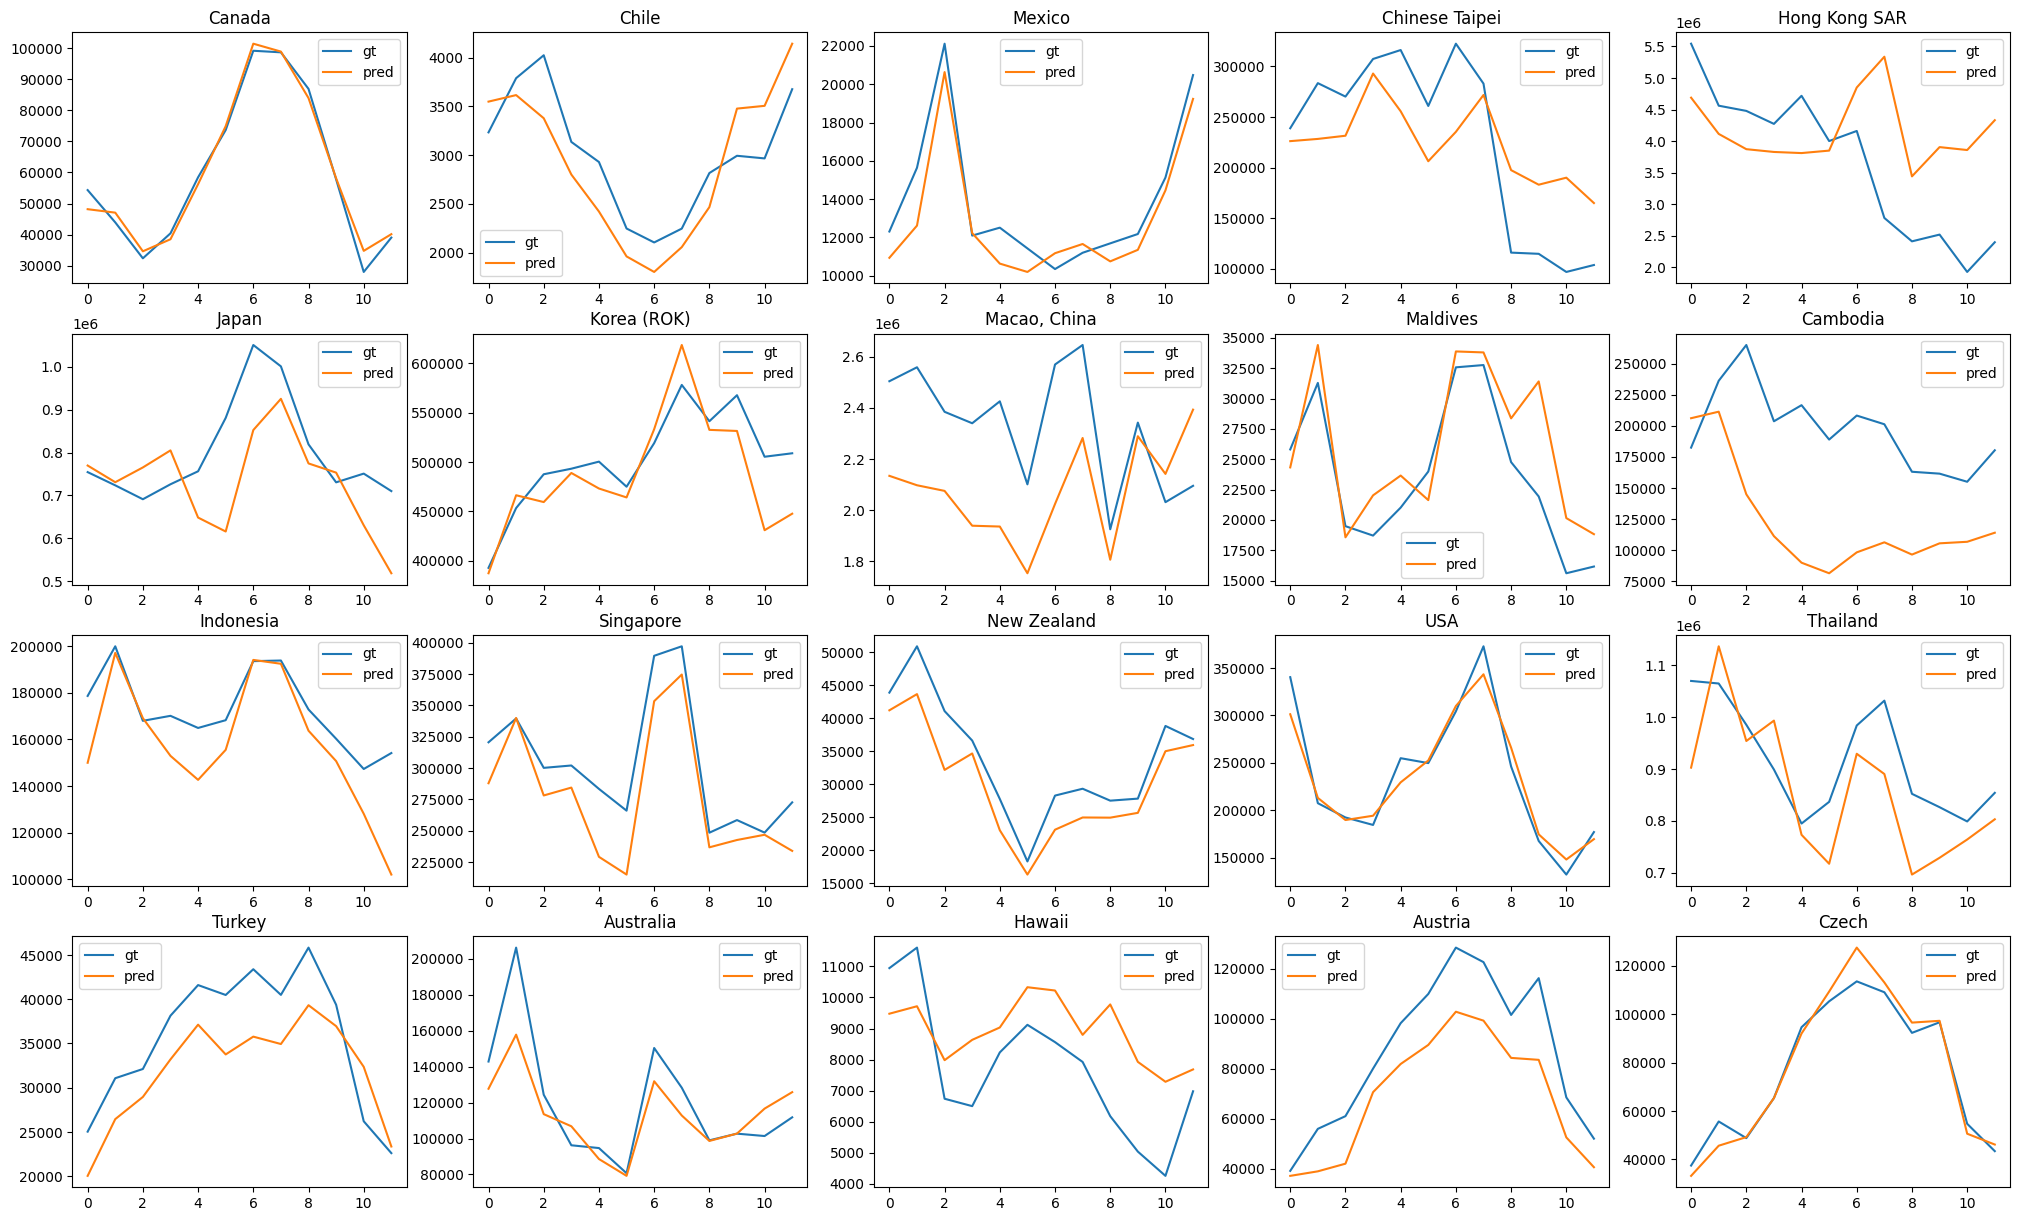

In [29]:
plt.figure(figsize=(25, 15))
for i, country in enumerate(country_list):
    plt.subplot(4, 5, i+1)
    plt.plot(all_y[i*12:i*12+12], label='gt')
    plt.plot(reg_pred[i*12:i*12+12], label='pred')
    plt.legend()
    plt.title(country)
plt.show()

In [30]:
reg_rmse = sqrt(mean_squared_error(all_y, reg_pred))
reg_r2 = r2_score(all_y, reg_pred)
reg_mae = mean_absolute_error(all_y, reg_pred)
reg_mape = mean_absolute_percentage_error(all_y, reg_pred)
reg_mase = mean_absolute_scaled_error(all_y, reg_pred, y_mase_scales)
print(f'Baseline Model RMSE: {reg_rmse:.5f}\nBaseline Model R2: {reg_r2:.5f}'
      f'\nBaseline Model MAE: {reg_mae:.5f}\nBaseline Model MAPE: {reg_mape:.5f}\nBaseline Model MASE: {reg_mase:.5f}')

Baseline Model RMSE: 301275.03416
Baseline Model R2: 0.89519
Baseline Model MAE: 92607.64526
Baseline Model MAPE: 0.15221
Baseline Model MASE: 1.79878


## Combination Regression Model

In [31]:
country_feat = [#'GDPPerCap', 'GDP', 'Population', 
                'Temperature', 'Precipitation',]
universal_feat = ['FXAgainstChina', 'FSI',
                   'DistFromChina', 'GDPRatioChina', 'Unrest', 'MonthSin', 'MonthCos', 'Year',
                   'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina',
                   'ChinaConfinementPolicy', 'ChinaMovementPolicy', 'ChinaGDPPerCap',
                   'ChinaGDP', 'Popularity', 'TravelRestriction']

In [32]:
# repeat for all countries
all_train_x, all_train_y, all_test_x, all_test_y = [], [], [], []
for country, df in all_data.items():
    df = df.copy().dropna()
    train_x, train_y = df[country_feat + universal_feat], df[target]
    train_y, train_x, _ = dummy_lagged_df(train_y, train_x, lag=1)
    train_x, test_x, train_y, test_y = train_x.iloc[:-1*12], train_x.iloc[-1*12:], train_y.iloc[:-1*12], train_y.iloc[-1*12:]
    
    all_train_x.append(train_x)
    all_train_y.append(train_y)
    all_test_x.append(test_x)
    all_test_y.append(test_y)

all_train_x = pd.concat(all_train_x, ignore_index=True)
all_train_y = pd.concat(all_train_y, ignore_index=True)
# best_param, best_rmse = grid_search_ml(all_train_x, all_train_y, preprocess=['nopreprocess'],#sample_weight=sample_weight,
#                                       model_types=['rf', 'xgb'], 
#                                        additional_params={'rf': [{'n_estimators': n} for n in (10, 50, 100, 150, 200, 300, 500)],
#                                                           'xgb': [{'n_estimators': n} for n in (10, 50, 100, 150, 200, 300, 500)]})

In [219]:
best_param, best_rmse = ('xgb', 'nopreprocess', {'objective': 'reg:squarederror', 'n_estimators': 250}), 0.14275667605963807
print(best_param, best_rmse)
model = get_model(best_param[0])
model = model.set_params(**best_param[2])
scaler = get_scaler(best_param[1])
all_train_x_ = scaler.fit_transform(all_train_x)
model.fit(all_train_x_, all_train_y,)# sample_weight=sample_weight)

reg_comb_pred, all_comb_y = [], []
for country, test_x, test_y in zip(all_data.keys(), all_test_x, all_test_y):
    test_x_ = scaler.transform(test_x)
    pred = model.predict(test_x_)
    
    reg_comb_pred.append(inverse_target(pred, all_decomposed_seasonal[country].seasonal.loc[test_y.index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                        y_scaler if single_y_scaler else y_scaler[country]))
    all_comb_y.append(inverse_target(test_y, all_decomposed_seasonal[country].seasonal.loc[test_y.index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                     y_scaler if single_y_scaler else y_scaler[country]))

reg_comb_pred, all_comb_y = np.concatenate(reg_comb_pred), np.concatenate(all_comb_y)

('xgb', 'nopreprocess', {'objective': 'reg:squarederror', 'n_estimators': 250}) 0.14275667605963807


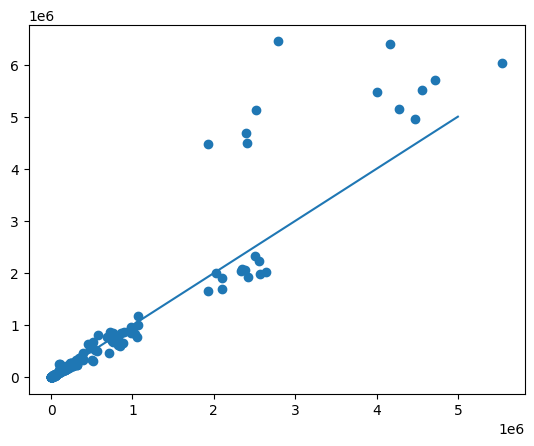

In [220]:
plt.scatter(all_y, reg_comb_pred)
plt.plot((0, 5000000), (0, 5000000))

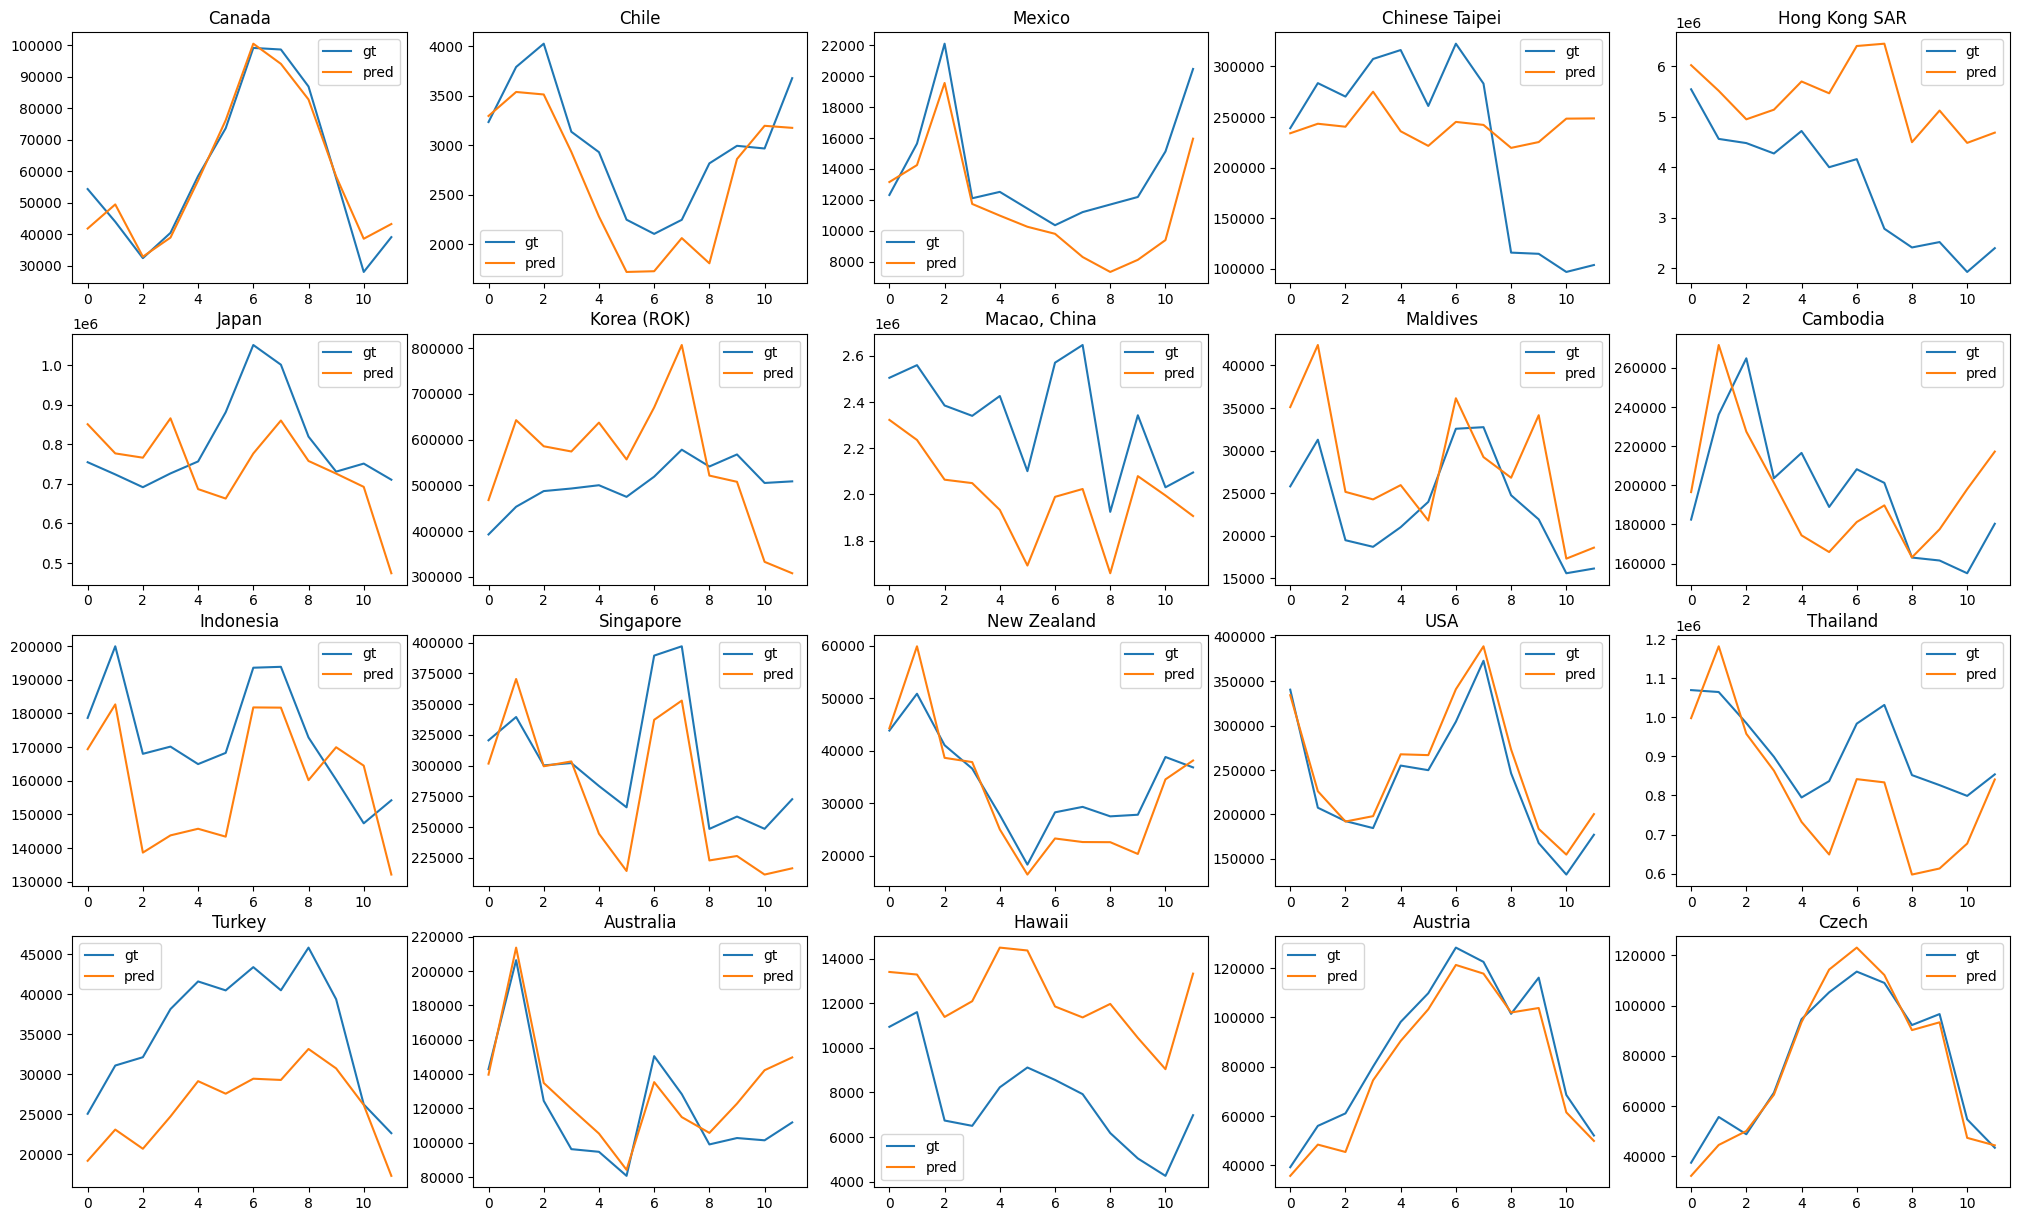

In [221]:
plt.figure(figsize=(25, 15))
for i, country in enumerate(country_list):
    plt.subplot(4, 5, i+1)
    plt.plot(all_y[i*12:i*12+12], label='gt')
    plt.plot(reg_comb_pred[i*12:i*12+12], label='pred')
    plt.legend()
    plt.title(country)
plt.show()

In [222]:
(all_y == all_comb_y).all()

True

In [223]:
# inaccurate because we use actual data to predict
comb_rmse = sqrt(mean_squared_error(all_y, reg_comb_pred))
comb_r2 = r2_score(all_y, reg_comb_pred)
comb_mae = mean_absolute_error(all_y, reg_comb_pred)
comb_mape = mean_absolute_percentage_error(all_y, reg_comb_pred)
comb_mase = mean_absolute_scaled_error(all_y, reg_comb_pred, y_mase_scales)
print(f'Combination Model RMSE: {comb_rmse:.5f}\nCombination Model R2: {comb_r2:.5f}'
      f'\nCombination Model MAE: {comb_mae:.5f}\nCombination Model MAPE: {comb_mape:.5f}\nCombination Model MASE: {comb_mase:.5f}')

Combination Model RMSE: 451857.78432
Combination Model R2: 0.76423
Combination Model MAE: 131803.28993
Combination Model MAPE: 0.20882
Combination Model MASE: 2.05134


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

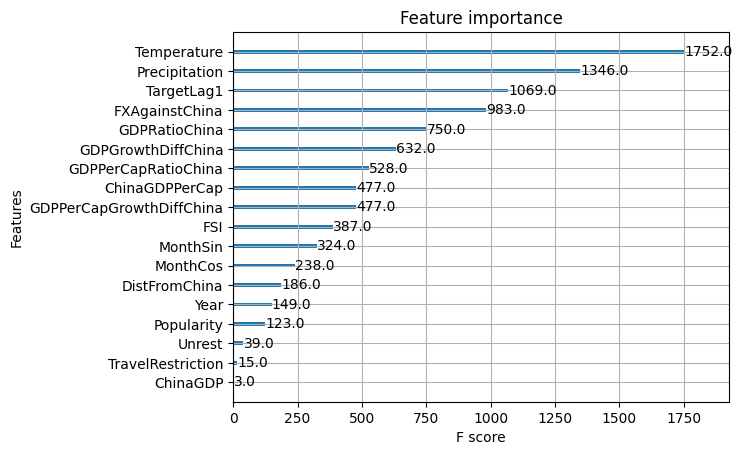

In [224]:
from xgboost import plot_importance
plot_importance(model)

In [225]:
# auto regressive predictions
reg_comb_pred, all_comb_y = [], []
for country, test_x, test_y in zip(all_data.keys(), all_test_x, all_test_y):
    test_x_ = scaler.transform(test_x)
    pred = []
    for i in range(len(test_x_)):
        if i > 0:
            test_x_.iloc[i:i+1, test_x_.columns.get_loc('TargetLag1')] = last_pred
        last_pred = model.predict(test_x_.iloc[i:i+1])
        pred.append(last_pred[0])
        
    pred = np.asarray(pred)
    
    reg_comb_pred.append(inverse_target(pred, all_decomposed_seasonal[country].seasonal.loc[test_y.index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                        y_scaler if single_y_scaler else y_scaler[country]))
    all_comb_y.append(inverse_target(test_y, all_decomposed_seasonal[country].seasonal.loc[test_y.index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                     y_scaler if single_y_scaler else y_scaler[country]))

reg_comb_pred, all_comb_y = np.concatenate(reg_comb_pred), np.concatenate(all_comb_y)

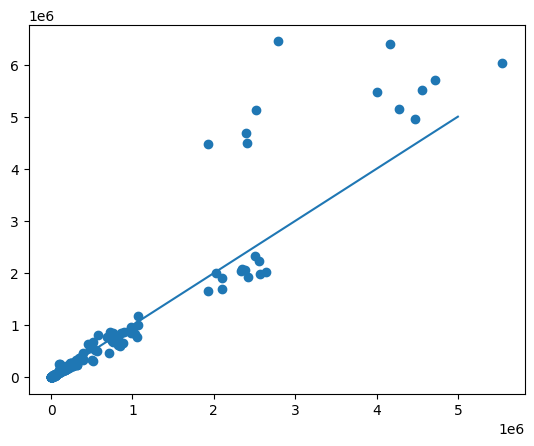

In [226]:
plt.scatter(all_y, reg_comb_pred)
plt.plot((0, 5000000), (0, 5000000))

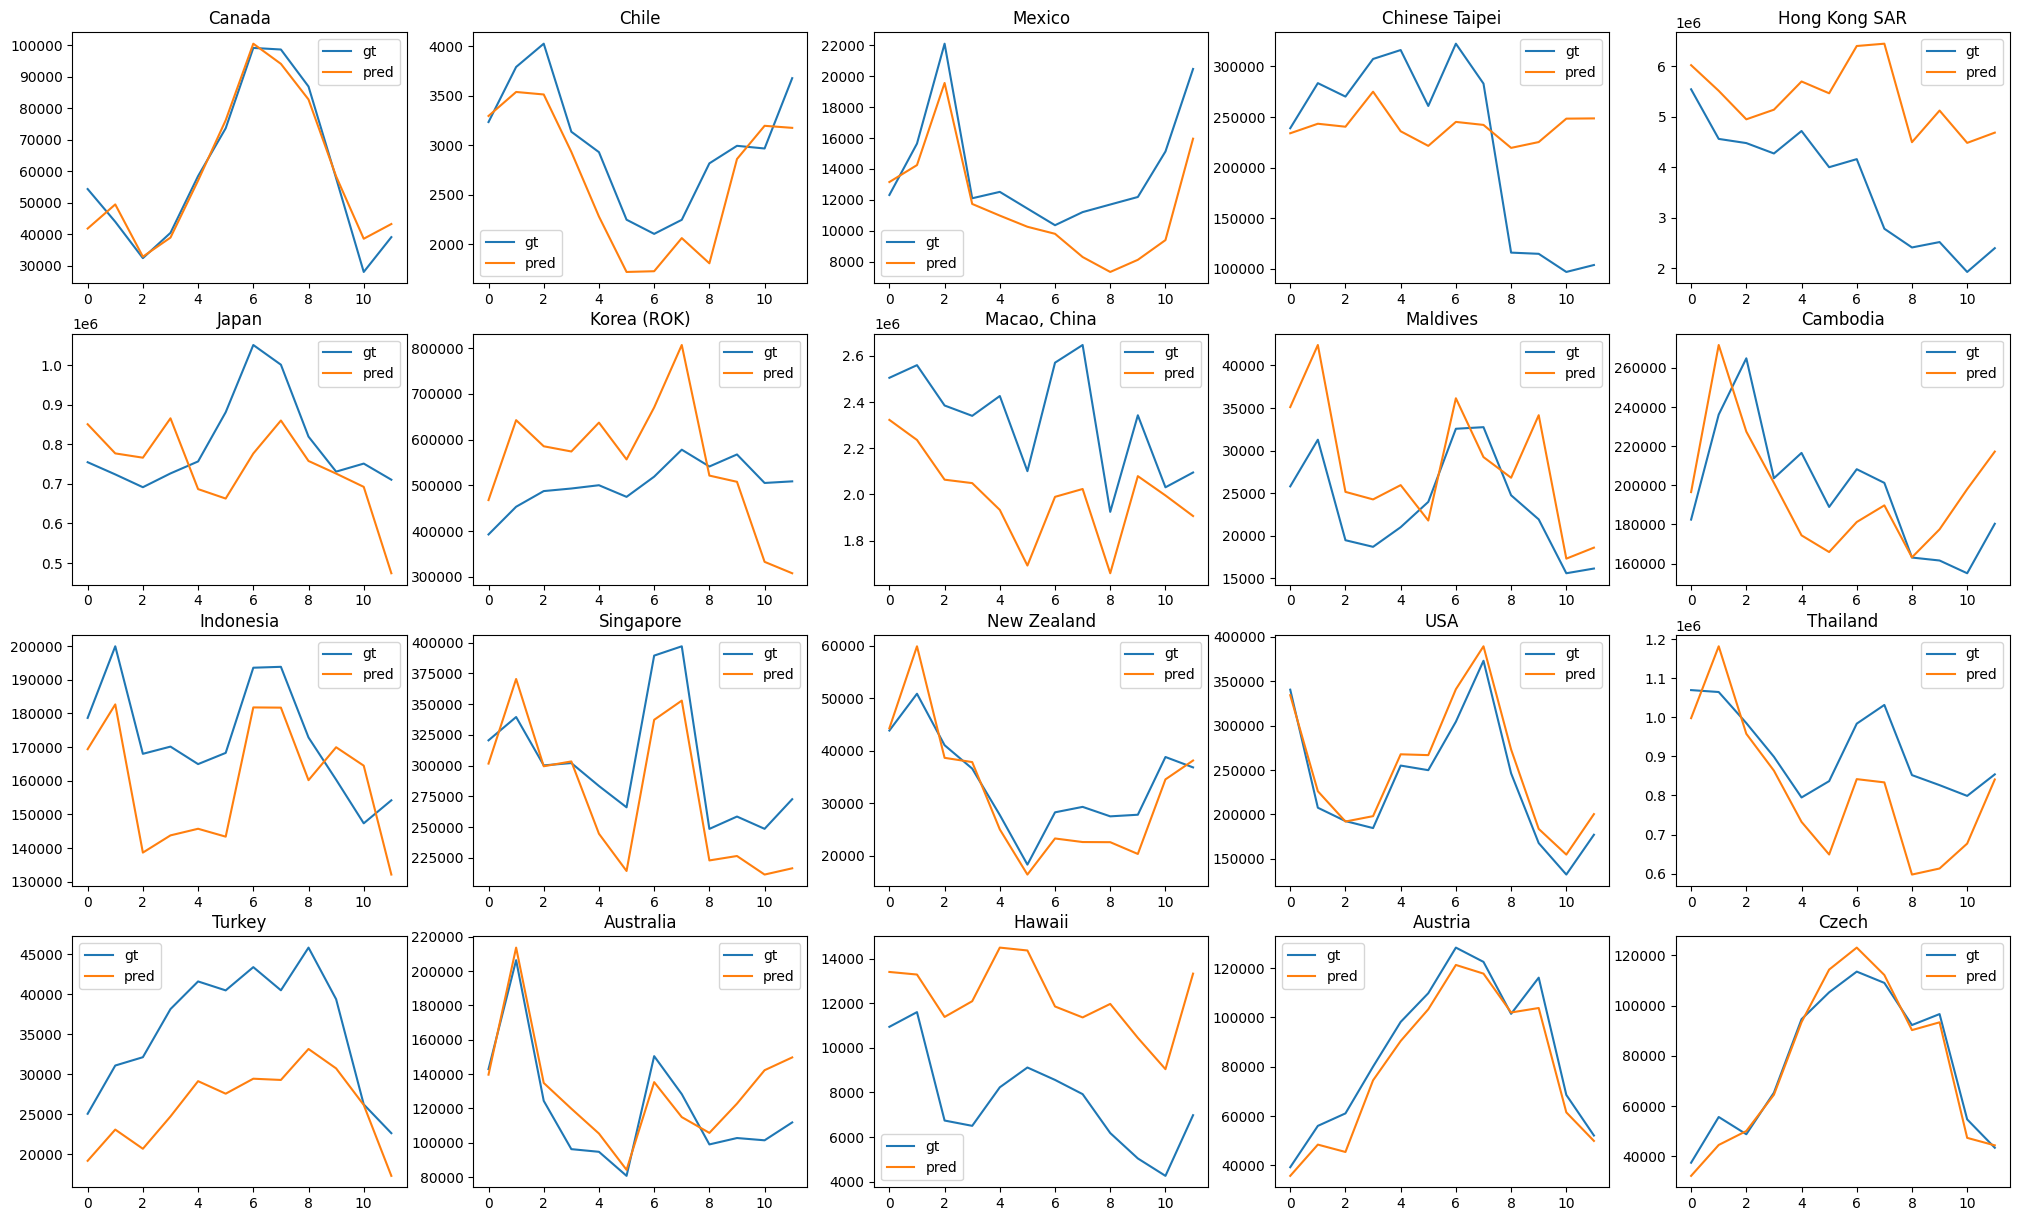

In [227]:
plt.figure(figsize=(25, 15))
for i, country in enumerate(country_list):
    plt.subplot(4, 5, i+1)
    plt.plot(all_y[i*12:i*12+12], label='gt')
    plt.plot(reg_comb_pred[i*12:i*12+12], label='pred')
    plt.legend()
    plt.title(country)
plt.show()

In [228]:
comb_rmse = sqrt(mean_squared_error(all_y, reg_comb_pred))
comb_r2 = r2_score(all_y, reg_comb_pred)
comb_mae = mean_absolute_error(all_y, reg_comb_pred)
comb_mape = mean_absolute_percentage_error(all_y, reg_comb_pred)
comb_mase = mean_absolute_scaled_error(all_y, reg_comb_pred, y_mase_scales)
print(f'Combination Model RMSE: {comb_rmse:.5f}\nCombination Model R2: {comb_r2:.5f}'
      f'\nCombination Model MAE: {comb_mae:.5f}\nCombination Model MAPE: {comb_mape:.5f}\nCombination Model MASE: {comb_mase:.5f}')

Combination Model RMSE: 451857.78432
Combination Model R2: 0.76423
Combination Model MAE: 131803.28993
Combination Model MAPE: 0.20882
Combination Model MASE: 2.05134


# RNN

In [72]:
country_feat = [#'GDPPerCap', 'GDP', 'Population',
                'Temperature', 'Precipitation',]
universal_feat = ['FXAgainstChina', 'FSI', 'Country', 
                   'GDPRatioChina', 'Unrest', 'MonthSin', 'MonthCos', 'Year',
                   'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina',
                   'ChinaConfinementPolicy', 'ChinaMovementPolicy', 'ChinaGDPPerCap',
                   'ChinaGDP', 'Popularity', 'TravelRestriction']
# static_feat = ['DistFromChina']
target = 'VisitorArrivals'
def sliding_window(df, input_len=100, output_len=12, test_size=1,):
    df = df.copy().dropna()
    x, y, mase = [], [], []
    if input_len <= 0:  # <=0 is full length
        input_len = len(df) - test_size * output_len * 2

    for i in range(len(df) - input_len - output_len + 1):
        x.append(df[country_feat + universal_feat + [target]].iloc[i: i + input_len])
        y.append(df[target].iloc[i + input_len: i + input_len + output_len].values)
        m = []
        for j in range(output_len):
            m.append(compute_mase_scale(df[target].iloc[: i + input_len + j].values, h=0))
        mase.append(m)
    y = np.asarray(y)
    mase = np.asarray(mase)
    return x[:-test_size*output_len], y[:-test_size*output_len], mase[:-test_size*output_len], x[-test_size:], y[-test_size:], mase[-test_size:]

In [73]:
seq_train_x, seq_train_y, mase_train, seq_test_x, seq_test_y, mase_test = sliding_window(all_data['Australia'], input_len=24, output_len=1, test_size=12)

In [74]:
seq_train_y.shape, mase_train.shape

((336, 1), (336, 1))

In [51]:
len(country_feat + universal_feat)

19

In [52]:
seq_train_x, seq_val_x, seq_train_y, seq_val_y = train_test_split(seq_train_x, seq_train_y, test_size=0.2, stratify=None)
train_dataset = TimeSeriesDataset(seq_train_x, seq_train_y,)# (model.num_layers, model.hidden_size))
val_dataset = TimeSeriesDataset(seq_val_x, seq_val_y,)# (model.num_layers, model.hidden_size))
test_dataset = TimeSeriesDataset(seq_test_x, seq_test_y,)# (model.num_layers, model.hidden_size))

In [53]:
len(train_dataset) + len(val_dataset)

336

In [54]:
def grid_search_rnn_custom(country_list, test_size=1, criterion_type='mse', model_types=None, input_size=19,
                    param_grids=None, max_epochs=50, verbose=True, cuda=True, output_len=12):
    if param_grids is None:
        param_grids = {}
    if model_types is None:
        model_types = ['lstm', 'gru']
    criterion = get_torch_criterion(criterion_type)

    best_score = np.inf
    best_param = None
    for seq_len in param_grids.get('seq_len', [24]):
        seq_train_x_ori, seq_train_y_ori, train_country = [], [], []
        for country in country_list:
            seq_train_x, seq_train_y, _, _ = sliding_window(all_data[country], input_len=seq_len, output_len=output_len, test_size=test_size)
            temp_country = [country] * len(seq_train_x)
            seq_train_x_ori.extend(seq_train_x)
            seq_train_y_ori.append(seq_train_y)
            train_country.extend(temp_country)
        seq_train_y_ori = np.concatenate(seq_train_y_ori)
        for batch_size in param_grids.get('batch_size', [128]):
            for model_type in model_types:
                for num_layers in param_grids.get('num_layers', range(2, 5)): 
                    for hidden_size in param_grids.get('hidden_size', [20, 40, 50, 60, 75, 100]):
                        for optim_type in param_grids.get('optim_type', ['nadam', 'rmsprop']):
                            for lr in [0.01, 0.005, 0.001, 0.0005, 0.0001]:
                                model = ForecastModel(model_type, input_size=input_size, output_size=output_len, num_layers=num_layers, hidden_size=hidden_size, conditional_labels=country_list,)
                                optimizer = get_torch_optimizer(optim_type, model.parameters(), lr=lr)
                                score_list = []
                                kf = StratifiedKFold()
                                for train_index, test_index in kf.split(seq_train_x_ori, train_country):
                                    seq_train_x, seq_val_x = [seq_train_x_ori[i] for i in train_index], [seq_train_x_ori[i] for i in test_index]
                                    seq_train_y, seq_val_y  = seq_train_y_ori[train_index], seq_train_y_ori[test_index]
                                    train_dataset = TimeSeriesDataset(seq_train_x, seq_train_y,)# (model.num_layers, model.hidden_size))
                                    val_dataset = TimeSeriesDataset(seq_val_x, seq_val_y,)# (model.num_layers, model.hidden_size))
                                    train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, pin_memory=True)
                                    val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=1, pin_memory=True)
                                    model, train_losses, val_losses = train_rnn(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=max_epochs, verbose=False, cuda=cuda)

                                    score_list.append(sqrt(val_losses[-1]) if criterion_type == 'mse' else val_losses[-1])
                                score = np.mean(score_list)
                                if score < best_score:
                                    best_score = score
                                    best_param = ({'seq_len': seq_len, 'batch_size': batch_size}, {'model_type': model_type, 'num_layers': num_layers, 'hidden_size': hidden_size},
                                                  {'optim_type': optim_type, 'lr': lr})
                                if verbose:
                                    print(({'seq_len': seq_len, 'batch_size': batch_size}, {'model_type': model_type, 'num_layers': num_layers, 'hidden_size': hidden_size},
                                          {'optim_type': optim_type, 'lr': lr}), round(score, 5), round(np.std(score_list), 5))
    return best_param, best_score

In [81]:
# best_param, best_rmse = grid_search_rnn_custom(country_list, model_types=['gru'])
# best_param, best_rmse

({'seq_len': 24, 'batch_size': 128}, {'model_type': 'gru', 'num_layers': 2, 'hidden_size': 20}, {'optim_type': 'nadam', 'lr': 0.01}) 0.33325 0.10413
({'seq_len': 24, 'batch_size': 128}, {'model_type': 'gru', 'num_layers': 2, 'hidden_size': 20}, {'optim_type': 'nadam', 'lr': 0.005}) 0.30092 0.03805
({'seq_len': 24, 'batch_size': 128}, {'model_type': 'gru', 'num_layers': 2, 'hidden_size': 20}, {'optim_type': 'nadam', 'lr': 0.001}) 0.29114 0.04483
({'seq_len': 24, 'batch_size': 128}, {'model_type': 'gru', 'num_layers': 2, 'hidden_size': 20}, {'optim_type': 'nadam', 'lr': 0.0005}) 0.29155 0.04758
({'seq_len': 24, 'batch_size': 128}, {'model_type': 'gru', 'num_layers': 2, 'hidden_size': 20}, {'optim_type': 'rmsprop', 'lr': 0.01}) 0.35511 0.07434
({'seq_len': 24, 'batch_size': 128}, {'model_type': 'gru', 'num_layers': 2, 'hidden_size': 20}, {'optim_type': 'rmsprop', 'lr': 0.005}) 0.33833 0.04934
({'seq_len': 24, 'batch_size': 128}, {'model_type': 'gru', 'num_layers': 2, 'hidden_size': 20}, {

({'seq_len': 24, 'batch_size': 128}, {'model_type': 'gru', 'num_layers': 2, 'hidden_size': 40}, {'optim_type': 'nadam', 'lr': 0.01}) 0.29219 0.05083
({'seq_len': 24, 'batch_size': 128}, {'model_type': 'gru', 'num_layers': 2, 'hidden_size': 40}, {'optim_type': 'nadam', 'lr': 0.005}) 0.28677 0.02497
({'seq_len': 24, 'batch_size': 128}, {'model_type': 'gru', 'num_layers': 2, 'hidden_size': 40}, {'optim_type': 'nadam', 'lr': 0.001}) 0.28093 0.03469
({'seq_len': 24, 'batch_size': 128}, {'model_type': 'gru', 'num_layers': 2, 'hidden_size': 40}, {'optim_type': 'nadam', 'lr': 0.0005}) 0.28022 0.03953
({'seq_len': 24, 'batch_size': 128}, {'model_type': 'gru', 'num_layers': 2, 'hidden_size': 40}, {'optim_type': 'rmsprop', 'lr': 0.01}) 0.51477 0.0739
({'seq_len': 24, 'batch_size': 128}, {'model_type': 'gru', 'num_layers': 2, 'hidden_size': 40}, {'optim_type': 'rmsprop', 'lr': 0.005}) 0.36408 0.11254
({'seq_len': 24, 'batch_size': 128}, {'model_type': 'gru', 'num_layers': 2, 'hidden_size': 40}, {'

({'seq_len': 24, 'batch_size': 128}, {'model_type': 'gru', 'num_layers': 2, 'hidden_size': 60}, {'optim_type': 'nadam', 'lr': 0.01}) 0.35919 0.11394
({'seq_len': 24, 'batch_size': 128}, {'model_type': 'gru', 'num_layers': 2, 'hidden_size': 60}, {'optim_type': 'nadam', 'lr': 0.005}) 0.28573 0.0265
({'seq_len': 24, 'batch_size': 128}, {'model_type': 'gru', 'num_layers': 2, 'hidden_size': 60}, {'optim_type': 'nadam', 'lr': 0.001}) 0.281 0.04066
({'seq_len': 24, 'batch_size': 128}, {'model_type': 'gru', 'num_layers': 2, 'hidden_size': 60}, {'optim_type': 'nadam', 'lr': 0.0005}) 0.27956 0.03559
({'seq_len': 24, 'batch_size': 128}, {'model_type': 'gru', 'num_layers': 2, 'hidden_size': 60}, {'optim_type': 'rmsprop', 'lr': 0.01}) 0.44359 0.12125
({'seq_len': 24, 'batch_size': 128}, {'model_type': 'gru', 'num_layers': 2, 'hidden_size': 60}, {'optim_type': 'rmsprop', 'lr': 0.005}) 0.41906 0.09199
({'seq_len': 24, 'batch_size': 128}, {'model_type': 'gru', 'num_layers': 2, 'hidden_size': 60}, {'op

(({'seq_len': 24, 'batch_size': 128},
  {'model_type': 'gru', 'num_layers': 2, 'hidden_size': 50},
  {'optim_type': 'nadam', 'lr': 0.005}),
 0.2790603226413674)

In [55]:
output_size=12
seq_train_x_ori, seq_train_y_ori, seq_test_x_ori, seq_test_y_ori = [], [], [], []
for country in country_list:
    seq_train_x, seq_train_y, _, seq_test_x, seq_test_y, _ = sliding_window(all_data[country], input_len=60, 
                                                                      output_len=12, test_size=1)
    temp_country = [country] * len(seq_train_x)
    seq_train_x_ori.extend(seq_train_x)
    seq_train_y_ori.append(seq_train_y)
    seq_test_x_ori.extend(seq_test_x)
    seq_test_y_ori.append(seq_test_y)
seq_train_y_ori = np.concatenate(seq_train_y_ori)
seq_test_y_ori = np.concatenate(seq_test_y_ori)

In [56]:
seq_train_y_ori.shape, seq_test_y_ori.shape

((2717, 12), (20, 12))

Epoch 0: train loss 1.8407, val loss 1.2628, time 1.3358
Epoch 1: train loss 0.8962, val loss 0.9856, time 1.1753
Epoch 2: train loss 0.8154, val loss 0.8859, time 1.1778
Epoch 3: train loss 0.7834, val loss 0.9006, time 1.1733
Epoch 4: train loss 0.7563, val loss 0.8282, time 1.1718
Epoch 5: train loss 0.7516, val loss 0.8570, time 1.1734
Epoch 6: train loss 0.7333, val loss 0.8724, time 1.1843
Epoch 7: train loss 0.7315, val loss 0.7943, time 1.1991
Epoch 8: train loss 0.7187, val loss 0.7990, time 1.1766
Epoch 9: train loss 0.7214, val loss 0.8046, time 1.1755
Epoch 10: train loss 0.7098, val loss 0.8424, time 1.1709
Epoch 11: train loss 0.7021, val loss 0.7981, time 1.1714
Epoch 12: train loss 0.6936, val loss 0.7910, time 1.1709
Epoch 13: train loss 0.6923, val loss 0.7711, time 1.1731
Epoch 14: train loss 0.6928, val loss 0.7856, time 1.1792
Epoch 15: train loss 0.6920, val loss 0.7994, time 1.1763
Epoch 16: train loss 0.6840, val loss 0.8236, time 1.1739
Early stopping as no imp

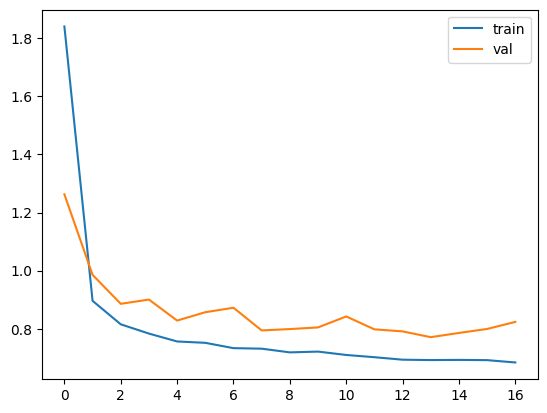

In [112]:
best_param = ({'seq_len': 24, 'batch_size': 128},
              {'model_type': 'gru', 'num_layers': 3, 'hidden_size': 50},
              {'optim_type': 'nadam', 'lr': 0.001})

output_size=12
seq_train_x_ori, seq_train_y_ori, train_mase_ori, seq_test_x_ori, seq_test_y_ori, test_mase_ori = [], [], [], [], [], []
for country in country_list:
    seq_train_x, seq_train_y, train_mase, seq_test_x, seq_test_y, test_mase = sliding_window(all_data[country], input_len=best_param[0]['seq_len'], 
                                                                                          output_len=output_size, test_size=1)
    temp_country = [country] * len(seq_train_x)
    seq_train_x_ori.extend(seq_train_x)
    seq_train_y_ori.append(seq_train_y)
    seq_test_x_ori.extend(seq_test_x)
    seq_test_y_ori.append(seq_test_y)
    train_mase_ori.append(train_mase)
    test_mase_ori.append(test_mase)
seq_train_y_ori = np.concatenate(seq_train_y_ori)
seq_test_y_ori = np.concatenate(seq_test_y_ori)
train_mase_ori = np.concatenate(train_mase_ori)
test_mase_ori = np.concatenate(test_mase_ori)

model = ForecastModel(**best_param[1], input_size=19, output_size=output_size, conditional_labels=country_list)
optimizer = get_torch_optimizer(best_param[2]['optim_type'], model.parameters(), lr=best_param[2]['lr'])
criterion = get_torch_criterion('mase')

train_dataset = TimeSeriesDataset(seq_train_x_ori, seq_train_y_ori, mases=train_mase_ori)# (model.num_layers, model.hidden_size))
test_dataset = TimeSeriesDataset(seq_test_x_ori, seq_test_y_ori, mases=test_mase_ori)# (model.num_layers, model.hidden_size))
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=best_param[0]['batch_size'], pin_memory=True)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1, pin_memory=True)

model, train_losses, val_losses = train_rnn(model, criterion, optimizer, train_dataloader, test_dataloader, cuda=True, epochs=100, mase=True)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend();

In [114]:
rnn_preds, _ = eval_rnn(model, criterion, test_dataloader, mase=True)

In [115]:
rnn_pred, rnn_gt = [], []

for i in range(len(test_dataset)):
    country, ds_x, ds_y, _ = test_dataset.__getitem__(i)
# for i, country in enumerate(all_data.keys()):
#     ds_y = rnn_gts[i]
    rnn_pred.append(inverse_target(rnn_preds[i], all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                   y_scaler if single_y_scaler else y_scaler[country]))
    rnn_gt.append(inverse_target(ds_y, all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                 y_scaler if single_y_scaler else y_scaler[country]))
rnn_gt = np.concatenate(rnn_gt)
rnn_pred = np.concatenate(rnn_pred)

In [116]:
(rnn_gt == all_y).all()

True

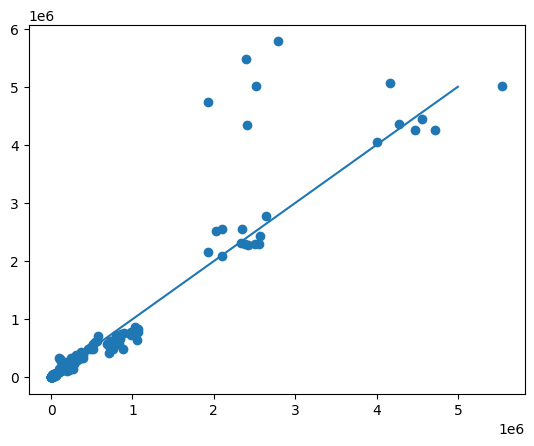

In [117]:
plt.scatter(all_y, rnn_pred)
plt.plot((0, 5000000), (0, 5000000))

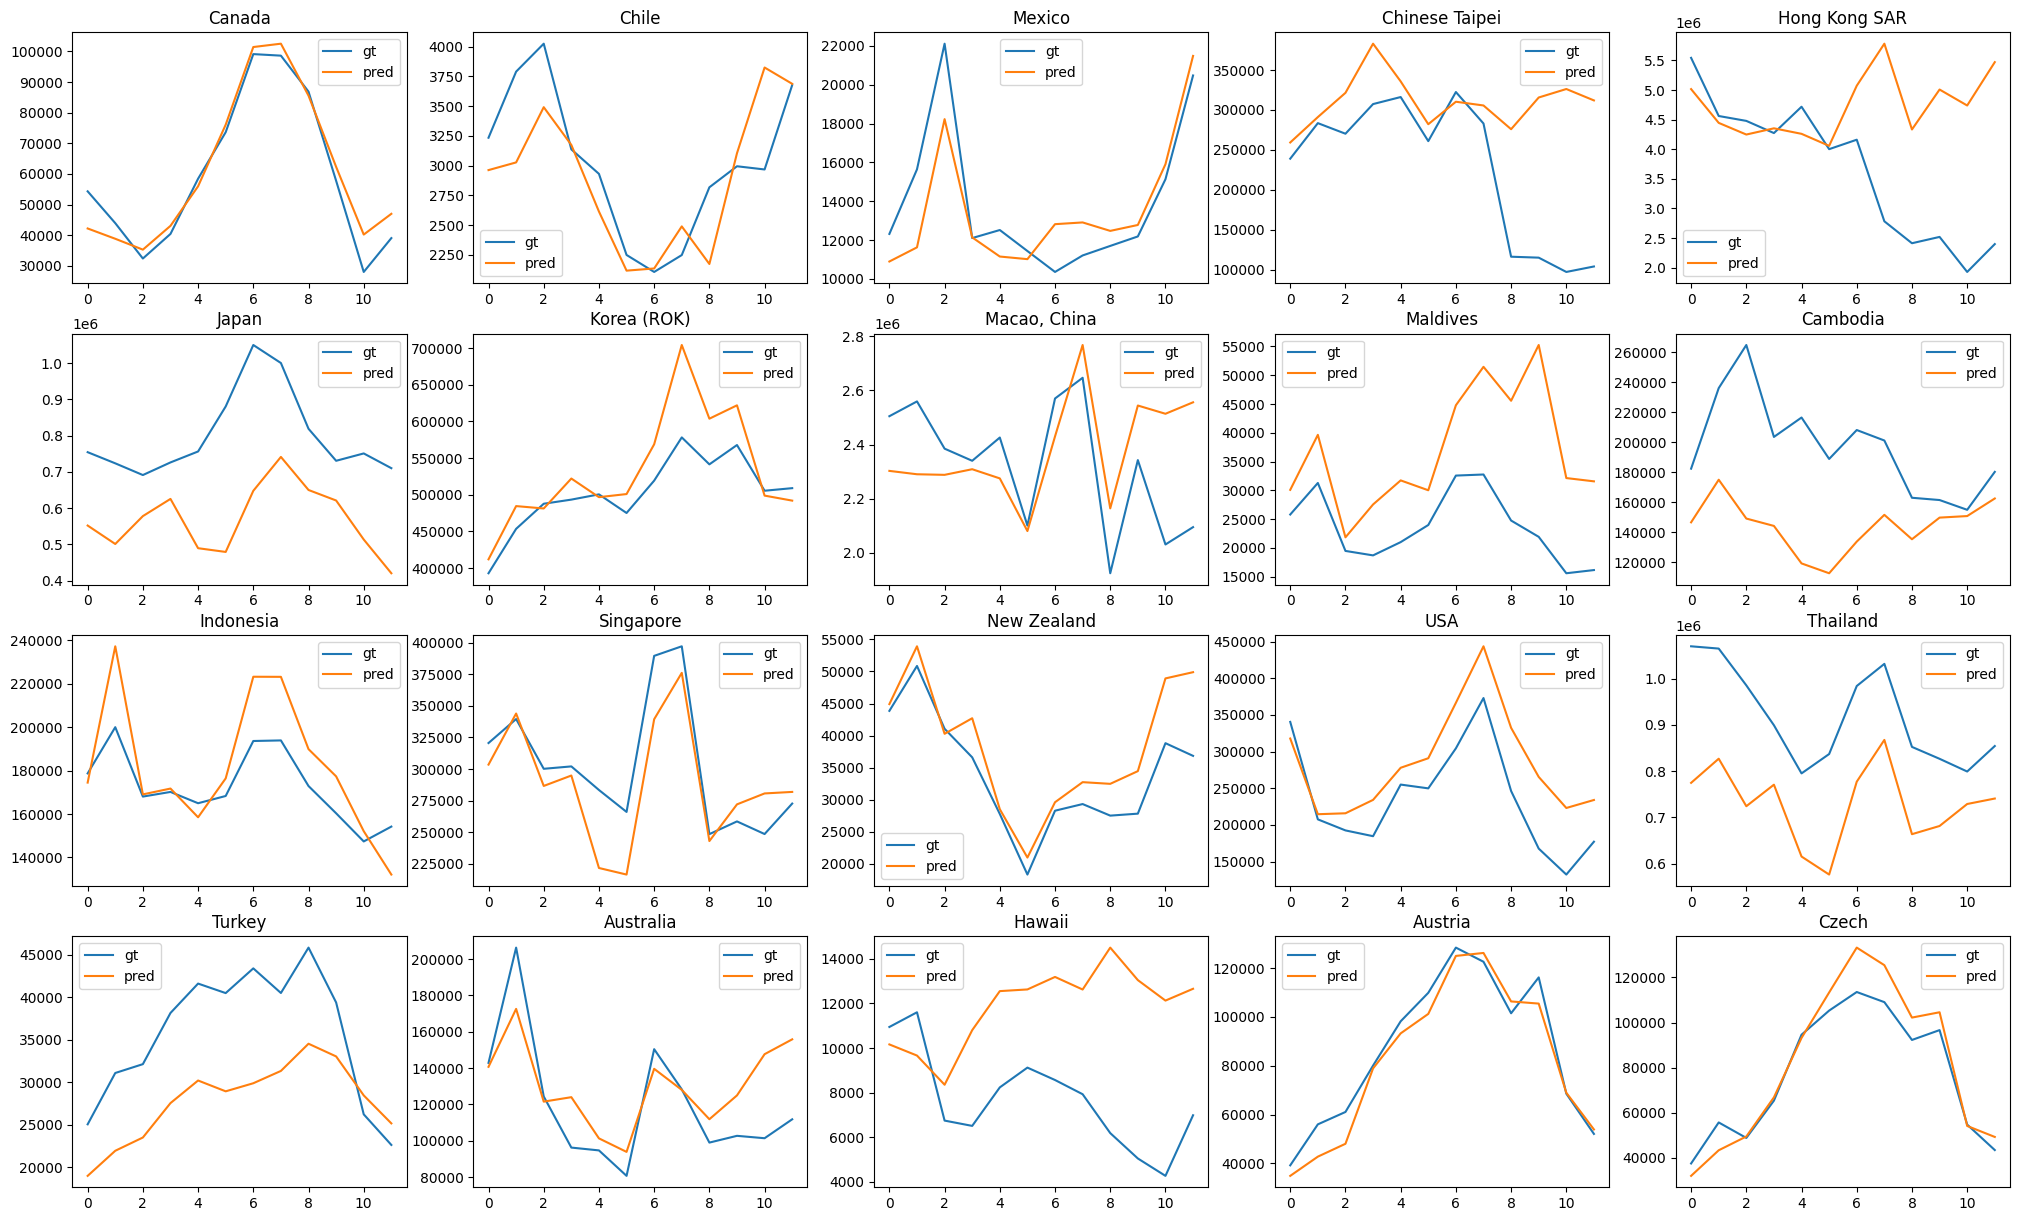

In [118]:
plt.figure(figsize=(25, 15))
for i, country in enumerate(country_list):
    plt.subplot(4, 5, i+1)
    plt.plot(all_y[i*12:i*12+12], label='gt')
    plt.plot(rnn_pred[i*12:i*12+12], label='pred')
    plt.legend()
    plt.title(country)
plt.show()

In [119]:
rnn_rmse = sqrt(mean_squared_error(all_y, rnn_pred))
rnn_r2 = r2_score(all_y, rnn_pred)
rnn_mae = mean_absolute_error(all_y, rnn_pred)
rnn_mape = mean_absolute_percentage_error(all_y, rnn_pred)
rnn_mase = mean_absolute_scaled_error(all_y, rnn_pred, y_mase_scales)
print(f'RNN RMSE: {rnn_rmse:.5f}\nRNN R2: {rnn_r2:.5f}'
      f'\nRNN MAE: {rnn_mae:.5f}\nRNN MAPE: {rnn_mape:.5f}\nRNN MASE: {rnn_mase:.5f}')

RNN RMSE: 407663.27391
RNN R2: 0.80809
RNN MAE: 113059.86607
RNN MAPE: 0.24399
RNN MASE: 2.46648


# One Step RNN

In [142]:
country_feat = [#'GDPPerCap', 'GDP', 'Population',
                'Temperature', 'Precipitation',]
universal_feat = ['FXAgainstChina', 'FSI', 'Country', 
                   'GDPRatioChina', 'Unrest', 'MonthSin', 'MonthCos', 'Year',
                   'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina',
                   'ChinaConfinementPolicy', 'ChinaMovementPolicy', 'ChinaGDPPerCap',
                   'ChinaGDP', 'Popularity', 'TravelRestriction']
# static_feat = ['DistFromChina']
target = 'VisitorArrivals'

In [143]:
len(country_feat + universal_feat)

19

In [144]:
def grid_search_rnn_custom(country_list, test_size=1, criterion_type='mae', model_types=None, input_size=19,
                    param_grids=None, max_epochs=50, verbose=True, cuda=True, output_len=12):
    if param_grids is None:
        param_grids = {}
    if model_types is None:
        model_types = ['lstm', 'gru']
    criterion = get_torch_criterion(criterion_type)

    best_score = np.inf
    best_param = None
    for seq_len in param_grids.get('seq_len', [36]):
        seq_train_x_ori, seq_train_y_ori, train_country = [], [], []
        for country in country_list:
            seq_train_x, seq_train_y, _, _ = sliding_window(all_data[country], input_len=seq_len, output_len=output_len, test_size=test_size)
            temp_country = [country] * len(seq_train_x)
            seq_train_x_ori.extend(seq_train_x)
            seq_train_y_ori.append(seq_train_y)
            train_country.extend(temp_country)
        seq_train_y_ori = np.concatenate(seq_train_y_ori).squeeze()
        for batch_size in param_grids.get('batch_size', [64, 128, 256]):
            for model_type in model_types:
                for num_layers in param_grids.get('num_layers', range(1, 4)): # 4 layers result in worse performance
                    for hidden_size in param_grids.get('hidden_size', [50, 75, 100]):
                        for optim_type in param_grids.get('optim_type', ['nadam', 'rmsprop']):
                            for lr in [0.001, 0.0005]:
                                model = ForecastModel(model_type, input_size=input_size, output_size=output_len, num_layers=num_layers, hidden_size=hidden_size, conditional_labels=country_list,)
                                optimizer = get_torch_optimizer(optim_type, model.parameters(), lr=lr)
                                score_list = []
                                kf = StratifiedKFold()
                                for train_index, test_index in kf.split(seq_train_x_ori, train_country):
                                    seq_train_x, seq_val_x = [seq_train_x_ori[i] for i in train_index], [seq_train_x_ori[i] for i in test_index]
                                    seq_train_y, seq_val_y  = seq_train_y_ori[train_index], seq_train_y_ori[test_index]
                                    train_dataset = TimeSeriesDataset(seq_train_x, seq_train_y,)# (model.num_layers, model.hidden_size))
                                    val_dataset = TimeSeriesDataset(seq_val_x, seq_val_y,)# (model.num_layers, model.hidden_size))
                                    train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, pin_memory=True)
                                    val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=1, pin_memory=True)
                                    model, train_losses, val_losses = train_rnn(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=max_epochs, verbose=False, cuda=cuda)

                                    score_list.append(sqrt(val_losses[-1]) if criterion_type == 'mse' else val_losses[-1])
                                score = np.mean(score_list)
                                if score < best_score:
                                    best_score = score
                                    best_param = ({'seq_len': seq_len, 'batch_size': batch_size}, {'model_type': model_type, 'num_layers': num_layers, 'hidden_size': hidden_size},
                                                  {'optim_type': optim_type, 'lr': lr})
                                if verbose:
                                    print(({'seq_len': seq_len, 'batch_size': batch_size}, {'model_type': model_type, 'num_layers': num_layers, 'hidden_size': hidden_size},
                                          {'optim_type': optim_type, 'lr': lr}), round(score, 5), round(np.std(score_list), 5))
    return best_param, best_score

In [ ]:
# best_param, best_rmse = grid_search_rnn_custom(country_list, test_size=12, output_len=1)
# best_param, best_rmse

Epoch 0: train loss 1.7560, val loss 0.8690, time 2.0685
Epoch 1: train loss 0.9174, val loss 0.9290, time 1.3940
Epoch 2: train loss 0.6984, val loss 0.7063, time 1.4020
Epoch 3: train loss 0.6042, val loss 0.6285, time 1.3968
Epoch 4: train loss 0.5793, val loss 0.6954, time 1.3954
Epoch 5: train loss 0.5888, val loss 0.6517, time 1.4083
Epoch 6: train loss 0.5523, val loss 0.5267, time 1.4027
Epoch 7: train loss 0.5356, val loss 0.6695, time 1.3993
Epoch 8: train loss 0.5772, val loss 0.4856, time 1.3902
Epoch 9: train loss 0.5239, val loss 0.4320, time 1.3931
Epoch 10: train loss 0.5130, val loss 0.4695, time 1.3917
Epoch 11: train loss 0.5017, val loss 0.5891, time 1.3924
Epoch 12: train loss 0.5144, val loss 0.6549, time 1.3972
Epoch 13: train loss 0.5047, val loss 0.4789, time 1.3907
Early stopping as no improvement in val loss


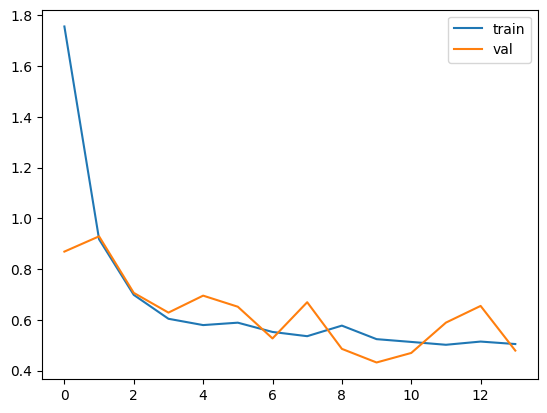

In [163]:
best_param = ({'seq_len': 24, 'batch_size': 256},
              {'model_type': 'gru', 'num_layers': 1, 'hidden_size': 100},
              {'optim_type': 'rmsprop', 'lr': 0.001})
output_size=1
seq_train_x_ori, seq_train_y_ori, train_mase_ori, seq_test_x_ori, seq_test_y_ori, test_mase_ori = [], [], [], [], [], []
for country in country_list:
    seq_train_x, seq_train_y, train_mase, seq_test_x, seq_test_y, test_mase = sliding_window(all_data[country], input_len=best_param[0]['seq_len'], 
                                                                      output_len=output_size, test_size=12)
    temp_country = [country] * len(seq_train_x)
    seq_train_x_ori.extend(seq_train_x)
    seq_train_y_ori.append(seq_train_y)
    seq_test_x_ori.extend(seq_test_x)
    seq_test_y_ori.append(seq_test_y)
    train_mase_ori.append(train_mase)
    test_mase_ori.append(test_mase)
seq_train_y_ori = np.concatenate(seq_train_y_ori).squeeze()
seq_test_y_ori = np.concatenate(seq_test_y_ori).squeeze()
train_mase_ori = np.concatenate(train_mase_ori).squeeze()
test_mase_ori = np.concatenate(test_mase_ori).squeeze()

model = ForecastModel(**best_param[1], input_size=19, output_size=output_size, conditional_labels=country_list)
optimizer = get_torch_optimizer(best_param[2]['optim_type'], model.parameters(), lr=best_param[2]['lr'])
criterion = get_torch_criterion('mase')

train_dataset = TimeSeriesDataset(seq_train_x_ori, seq_train_y_ori, mases=train_mase_ori)# (model.num_layers, model.hidden_size))
test_dataset = TimeSeriesDataset(seq_test_x_ori, seq_test_y_ori, mases=test_mase_ori)# (model.num_layers, model.hidden_size))
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=best_param[0]['batch_size'], pin_memory=True)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1, pin_memory=True)

model, train_losses, val_losses = train_rnn(model, criterion, optimizer, train_dataloader, test_dataloader, cuda=True, epochs=100, mase=True)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend();

In [164]:
# rnn_preds, _ = eval_rnn(model, criterion, test_dataloader)

# auto regressive predictions
model.eval()
rnn_preds, rnn_gts = [], []
for country in all_data.keys():
    test_x_, test_y_ = zip(*[(x.copy(), y.copy()) for x, y in zip(seq_test_x_ori, seq_test_y_ori) if x['Country'].unique()[0] == country])
    preds = []
    for i in range(len(test_x_)):
        if i > 0:
            last_pred = np.concatenate(preds)[-len(test_x_[i]):]
            test_x_[i].iloc[-len(last_pred):, test_x_[i].columns.get_loc('VisitorArrivals')] = last_pred
        with torch.no_grad():
            init_state = model.get_embeddings([country])
            x_input = torch.from_numpy(test_x_[i].drop(columns='Country').to_numpy()).float().unsqueeze(0)
            init_state, x_input = init_state.cuda(), x_input.cuda()
            pred = model(x_input, init_state).detach().cpu().numpy()
        preds.append(pred)
        
    preds = np.concatenate(preds)
    gts = np.asarray(test_y_)
    rnn_preds.append(preds)
    rnn_gts.append(gts)

rnn_preds = np.asarray(rnn_preds)
rnn_gts = np.asarray(rnn_gts)

# monte carlo sample
model.dropout.train()
model.rnn.train()
samples = []
for _ in range(100):
    temp = []
    for country in all_data.keys():
        test_x_, test_y_ = zip(*[(x.copy(), y.copy()) for x, y in zip(seq_test_x_ori, seq_test_y_ori) if x['Country'].unique()[0] == country])
        preds = []
        for i in range(len(test_x_)):
            if i > 0:
                last_pred = np.concatenate(preds)[-len(test_x_[i]):]
                test_x_[i].iloc[-len(last_pred):, test_x_[i].columns.get_loc('VisitorArrivals')] = last_pred
            with torch.no_grad():
                init_state = model.get_embeddings([country])
                x_input = torch.from_numpy(test_x_[i].drop(columns='Country').to_numpy()).float().unsqueeze(0)
                init_state, x_input = init_state.cuda(), x_input.cuda()
                pred = model(x_input, init_state).detach().cpu().numpy()
            preds.append(pred)

        preds = np.concatenate(preds)
        temp.append(preds)
    samples.append(np.asarray(temp))

In [165]:
rnn_os_pred, rnn_gt = [], []
rnn_os_sample = [[] for _ in range(len(samples))]

# for i in range(len(test_dataset)):
#     country, ds_x, ds_y = test_dataset.__getitem__(i)
for i, country in enumerate(all_data.keys()):
    ds_y = rnn_gts[i]
    rnn_os_pred.append(inverse_target(rnn_preds[i], all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                   y_scaler if single_y_scaler else y_scaler[country]))
    rnn_gt.append(inverse_target(ds_y, all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                 y_scaler if single_y_scaler else y_scaler[country]))
    
for j in range(len(samples)):
    for i, country in enumerate(all_data.keys()):
        rnn_os_sample[j].append(inverse_target(samples[j][i], all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                               y_scaler if single_y_scaler else y_scaler[country]))
    rnn_os_sample[j] = np.concatenate(rnn_os_sample[j])

rnn_gt = np.concatenate(rnn_gt)
rnn_os_pred = np.concatenate(rnn_os_pred)
rnn_os_sample = np.asarray(rnn_os_sample)

In [166]:
ci = get_confidence_interval(rnn_os_sample)
rnn_os_lower = rnn_os_pred - ci
rnn_os_upper = rnn_os_pred + ci

In [167]:
(rnn_gt == all_y).all()

True

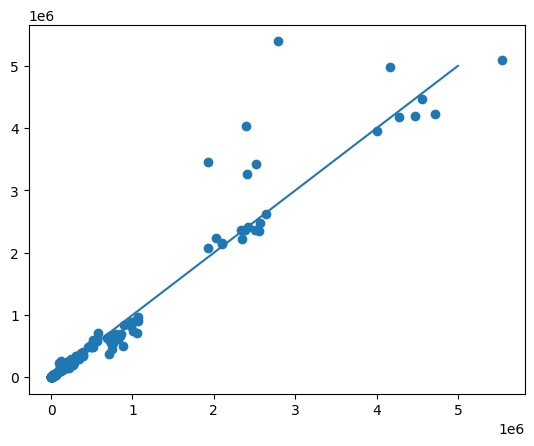

In [168]:
plt.scatter(all_y, rnn_os_pred)
plt.plot((0, 5000000), (0, 5000000))

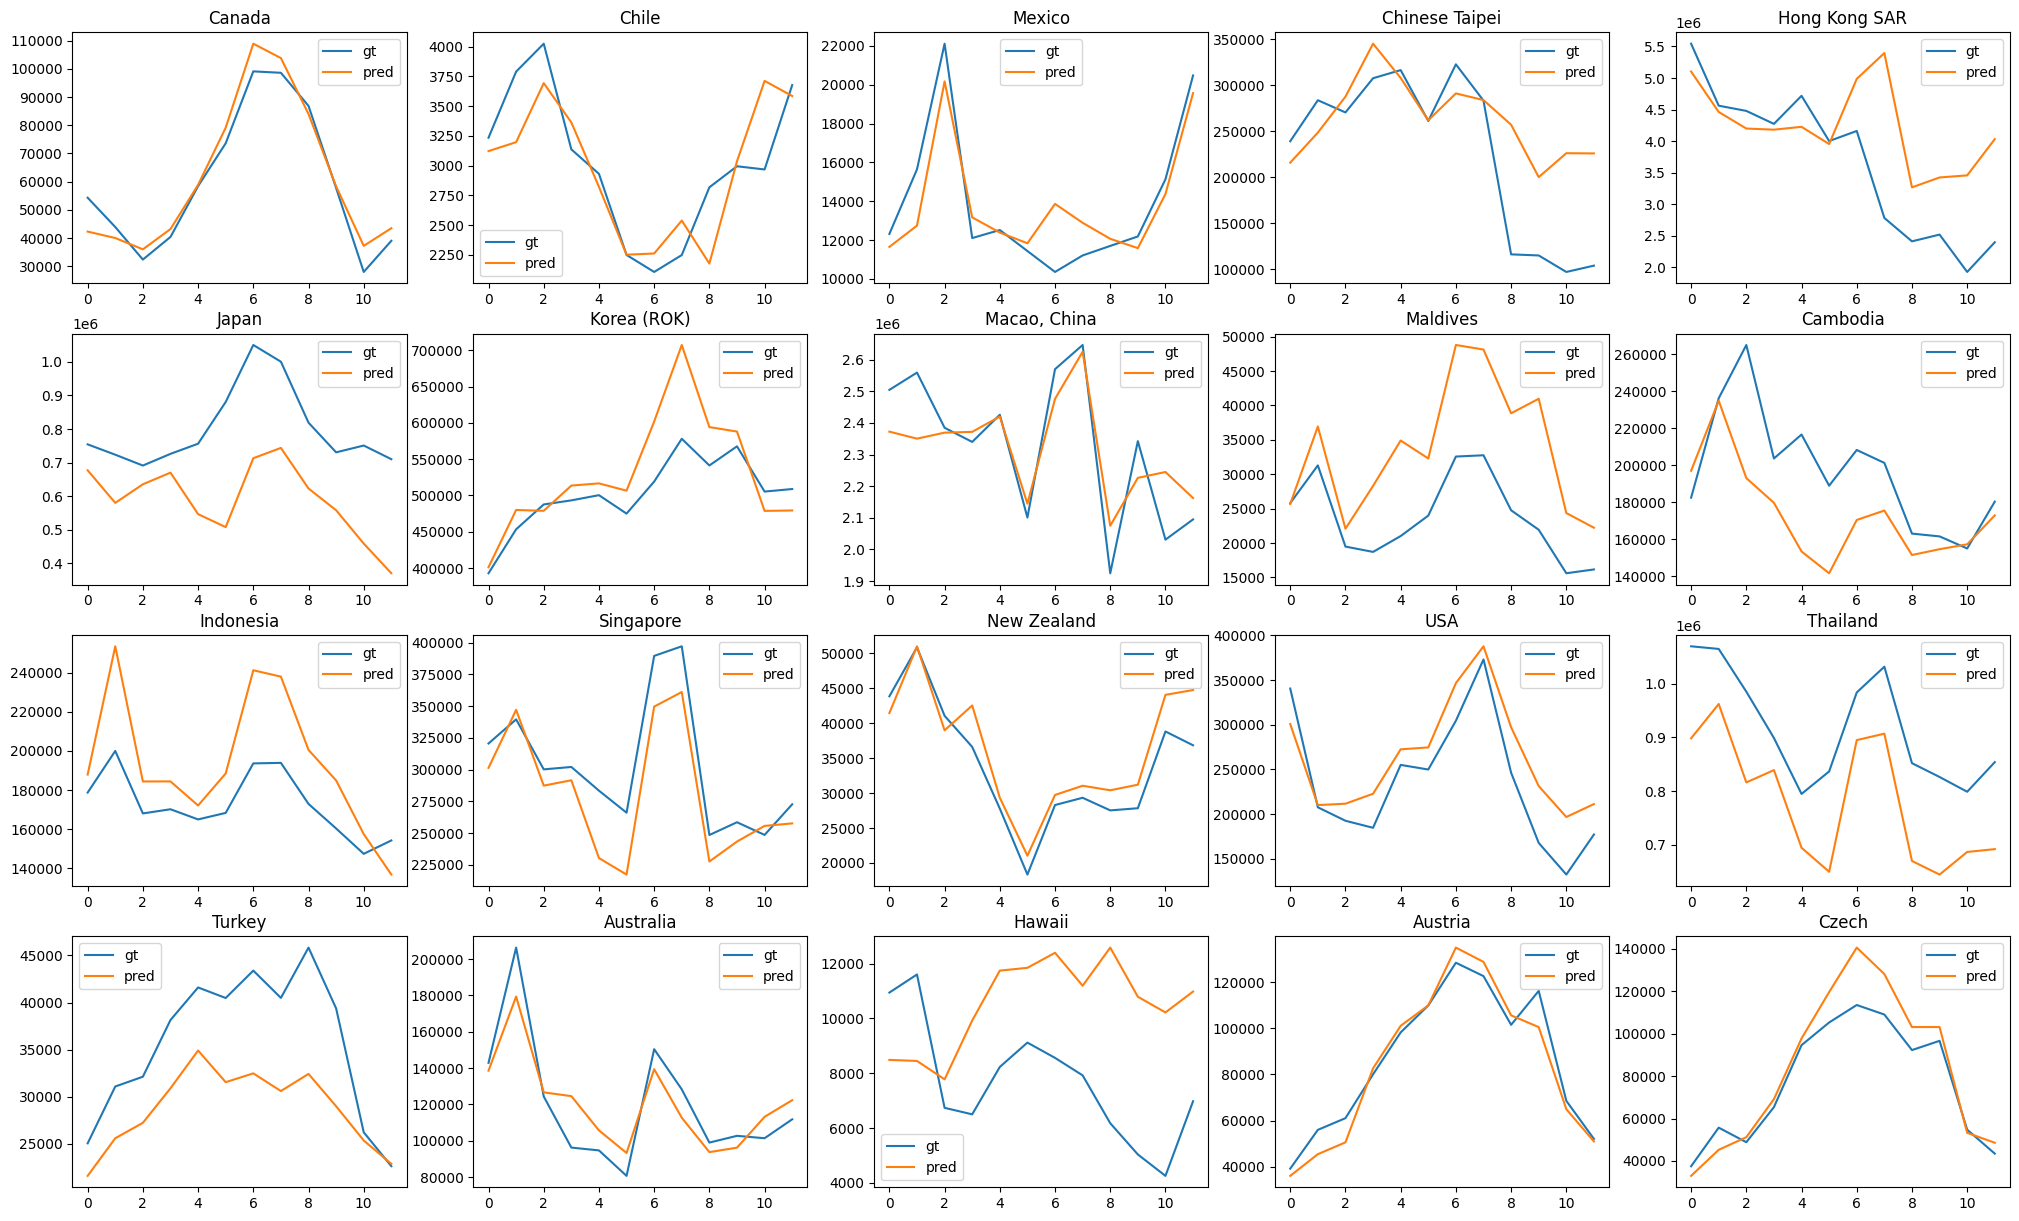

In [169]:
plt.figure(figsize=(25, 15))
for i, country in enumerate(country_list):
    plt.subplot(4, 5, i+1)
    plt.plot(all_y[i*12:i*12+12], label='gt')
    plt.plot(rnn_os_pred[i*12:i*12+12], label='pred')
    plt.legend()
    plt.title(country)
plt.show()

In [202]:
rnn_rmse = sqrt(mean_squared_error(all_y, rnn_os_pred))
rnn_r2 = r2_score(all_y, rnn_os_pred)
rnn_mae = mean_absolute_error(all_y, rnn_os_pred)
rnn_mape = mean_absolute_percentage_error(all_y, rnn_os_pred)
rnn_mase = mean_absolute_scaled_error(all_y, rnn_os_pred, y_mase_scales)
rnn_winkler = winkler_score(rnn_os_lower, rnn_os_upper, all_y)
print(f'RNN RMSE: {rnn_rmse:.5f}\nRNN R2: {rnn_r2:.5f}\nRNN MAE: {rnn_mae:.5f}'
      f'\nRNN MAPE: {rnn_mape:.5f}\nRNN MASE: {rnn_mase:.5f}\nRNN Winkler: {rnn_winkler:.5f}')

RNN RMSE: 256730.61097
RNN R2: 0.92389
RNN MAE: 75561.07973
RNN MAPE: 0.18032
RNN MASE: 1.83456
RNN Winkler: 693061.19177


# Separate RNN models

In [172]:
country_feat = [#'GDPPerCap', 'GDP', 'Population',
                'Temperature', 'Precipitation',]
universal_feat = ['FXAgainstChina', 'FSI', 'Country', 
                   'GDPRatioChina', 'Unrest', 'MonthSin', 'MonthCos', 'Year',
                   'GDPPerCapRatioChina', 'GDPGrowthDiffChina', 'GDPPerCapGrowthDiffChina',
                   'ChinaConfinementPolicy', 'ChinaMovementPolicy', 'ChinaGDPPerCap',
                   'ChinaGDP', 'TravelRestriction']
# static_feat = ['DistFromChina', 'Popularity']

Canada
Epoch 0: train loss 2.8776, val loss 6.8448, time 0.0741
Epoch 1: train loss 2.8273, val loss 6.7145, time 0.0615
Epoch 2: train loss 2.7720, val loss 6.5659, time 0.0614
Epoch 3: train loss 2.7135, val loss 6.4007, time 0.0614
Epoch 4: train loss 2.6370, val loss 6.2140, time 0.0620
Epoch 5: train loss 2.5397, val loss 6.0054, time 0.0612
Epoch 6: train loss 2.5277, val loss 5.7655, time 0.0612
Epoch 7: train loss 2.3923, val loss 5.5164, time 0.0602
Epoch 8: train loss 2.2966, val loss 5.2351, time 0.0660
Epoch 9: train loss 2.1468, val loss 4.8995, time 0.0613
Epoch 10: train loss 2.0468, val loss 4.5350, time 0.0613
Epoch 11: train loss 1.8691, val loss 4.1633, time 0.0603
Epoch 12: train loss 1.7411, val loss 3.7750, time 0.0622
Epoch 13: train loss 1.6744, val loss 3.4064, time 0.0603
Epoch 14: train loss 1.4627, val loss 3.0472, time 0.0612
Epoch 15: train loss 1.2974, val loss 2.7380, time 0.0611
Epoch 16: train loss 1.2431, val loss 2.4569, time 0.0661
Epoch 17: train l

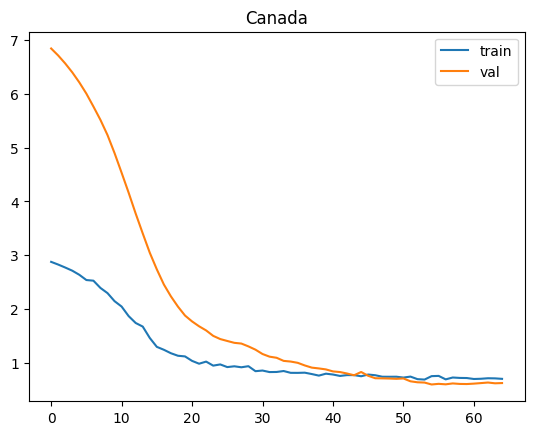

Chile
Epoch 0: train loss 2.4957, val loss 3.3265, time 0.0218
Epoch 1: train loss 2.4677, val loss 3.3164, time 0.0185
Epoch 2: train loss 2.4659, val loss 3.3052, time 0.0186
Epoch 3: train loss 2.5152, val loss 3.2973, time 0.0186
Epoch 4: train loss 2.3721, val loss 3.2851, time 0.0187
Epoch 5: train loss 2.4186, val loss 3.2692, time 0.0186
Epoch 6: train loss 2.3924, val loss 3.2623, time 0.0203
Epoch 7: train loss 2.3996, val loss 3.2450, time 0.0191
Epoch 8: train loss 2.4090, val loss 3.2331, time 0.0189
Epoch 9: train loss 2.4202, val loss 3.2192, time 0.0186
Epoch 10: train loss 2.3882, val loss 3.2071, time 0.0189
Epoch 11: train loss 2.3833, val loss 3.1941, time 0.0188
Epoch 12: train loss 2.3162, val loss 3.1837, time 0.0186
Epoch 13: train loss 2.3650, val loss 3.1715, time 0.0188
Epoch 14: train loss 2.3580, val loss 3.1587, time 0.0187
Epoch 15: train loss 2.3667, val loss 3.1502, time 0.0187
Epoch 16: train loss 2.3838, val loss 3.1402, time 0.0187
Epoch 17: train lo

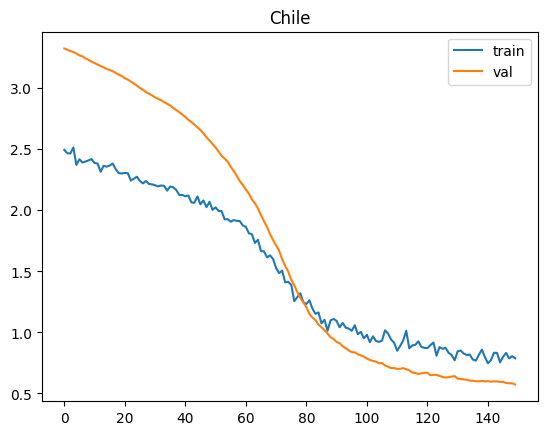

Mexico
Epoch 0: train loss 2.2623, val loss 4.6333, time 0.0589
Epoch 1: train loss 2.3984, val loss 4.5937, time 0.0511
Epoch 2: train loss 2.0768, val loss 4.5330, time 0.0501
Epoch 3: train loss 2.0519, val loss 4.4539, time 0.0498
Epoch 4: train loss 2.4574, val loss 4.3600, time 0.0510
Epoch 5: train loss 2.0886, val loss 4.2810, time 0.0518
Epoch 6: train loss 1.7730, val loss 4.1690, time 0.0499
Epoch 7: train loss 1.8621, val loss 4.0512, time 0.0505
Epoch 8: train loss 1.9777, val loss 3.9094, time 0.0513
Epoch 9: train loss 1.8210, val loss 3.7850, time 0.0496
Epoch 10: train loss 1.6337, val loss 3.6275, time 0.0491
Epoch 11: train loss 1.5376, val loss 3.4677, time 0.0491
Epoch 12: train loss 1.6321, val loss 3.3318, time 0.0488
Epoch 13: train loss 1.7481, val loss 3.1080, time 0.0506
Epoch 14: train loss 1.3058, val loss 2.9773, time 0.0508
Epoch 15: train loss 1.2210, val loss 2.8231, time 0.0503
Epoch 16: train loss 1.4162, val loss 2.6098, time 0.0499
Epoch 17: train l

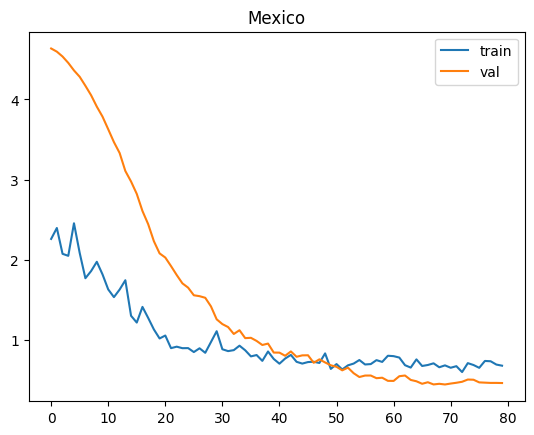

Chinese Taipei
Epoch 0: train loss 0.9826, val loss 1.5125, time 0.0400
Epoch 1: train loss 0.9153, val loss 1.4995, time 0.0347
Epoch 2: train loss 0.9281, val loss 1.4866, time 0.0353
Epoch 3: train loss 0.9540, val loss 1.4708, time 0.0394
Epoch 4: train loss 0.8681, val loss 1.4557, time 0.0470
Epoch 5: train loss 0.9293, val loss 1.4379, time 0.0349
Epoch 6: train loss 0.8579, val loss 1.4186, time 0.0355
Epoch 7: train loss 0.8837, val loss 1.3965, time 0.0351
Epoch 8: train loss 0.8359, val loss 1.3733, time 0.0358
Epoch 9: train loss 0.8471, val loss 1.3455, time 0.0350
Epoch 10: train loss 0.7859, val loss 1.3167, time 0.0348
Epoch 11: train loss 0.7804, val loss 1.2905, time 0.0344
Epoch 12: train loss 0.7799, val loss 1.2656, time 0.0343
Epoch 13: train loss 0.7636, val loss 1.2443, time 0.0343
Epoch 14: train loss 0.7408, val loss 1.2311, time 0.0352
Epoch 15: train loss 0.6995, val loss 1.2140, time 0.0342
Epoch 16: train loss 0.6940, val loss 1.2006, time 0.0340
Epoch 17:

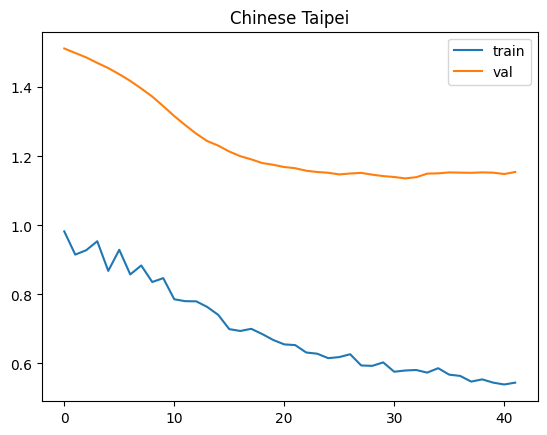

Hong Kong SAR
Epoch 0: train loss 3.1529, val loss 4.6835, time 0.0865
Epoch 1: train loss 2.9227, val loss 4.4953, time 0.0749
Epoch 2: train loss 2.8933, val loss 4.2757, time 0.0761
Epoch 3: train loss 2.7957, val loss 4.0279, time 0.0770
Epoch 4: train loss 2.6480, val loss 3.8301, time 0.0747
Epoch 5: train loss 2.4285, val loss 3.6221, time 0.0742
Epoch 6: train loss 2.3801, val loss 3.3527, time 0.0759
Epoch 7: train loss 2.3102, val loss 3.0621, time 0.0736
Epoch 8: train loss 2.1293, val loss 2.7618, time 0.0732
Epoch 9: train loss 1.9303, val loss 2.5255, time 0.0772
Epoch 10: train loss 1.7032, val loss 2.3953, time 0.0746
Epoch 11: train loss 1.4233, val loss 2.3132, time 0.0749
Epoch 12: train loss 1.3401, val loss 2.1865, time 0.0749
Epoch 13: train loss 1.2722, val loss 2.0547, time 0.0733
Epoch 14: train loss 1.3340, val loss 1.9157, time 0.0736
Epoch 15: train loss 1.1172, val loss 1.8143, time 0.0759
Epoch 16: train loss 1.0149, val loss 1.7532, time 0.0756
Epoch 17: 

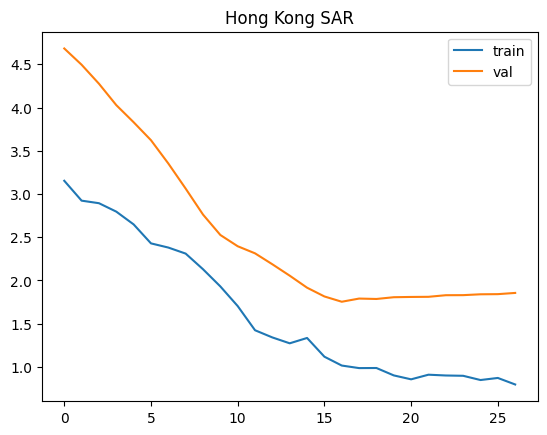

Japan
Epoch 0: train loss 5.1035, val loss 8.3799, time 0.0962
Epoch 1: train loss 4.8255, val loss 8.2450, time 0.0836
Epoch 2: train loss 4.7211, val loss 8.0965, time 0.0837
Epoch 3: train loss 4.4249, val loss 7.9378, time 0.0850
Epoch 4: train loss 4.2634, val loss 7.7738, time 0.0828
Epoch 5: train loss 4.1420, val loss 7.5959, time 0.0827
Epoch 6: train loss 3.9033, val loss 7.4038, time 0.0844
Epoch 7: train loss 3.6626, val loss 7.2071, time 0.0824
Epoch 8: train loss 3.4964, val loss 6.9946, time 0.0813
Epoch 9: train loss 3.2674, val loss 6.7633, time 0.0811
Epoch 10: train loss 3.0539, val loss 6.5333, time 0.0816
Epoch 11: train loss 2.9462, val loss 6.2942, time 0.0811
Epoch 12: train loss 2.7059, val loss 6.0531, time 0.0843
Epoch 13: train loss 2.6230, val loss 5.8212, time 0.0830
Epoch 14: train loss 2.4844, val loss 5.5930, time 0.0829
Epoch 15: train loss 2.3802, val loss 5.3806, time 0.0834
Epoch 16: train loss 2.3316, val loss 5.1641, time 0.0821
Epoch 17: train lo

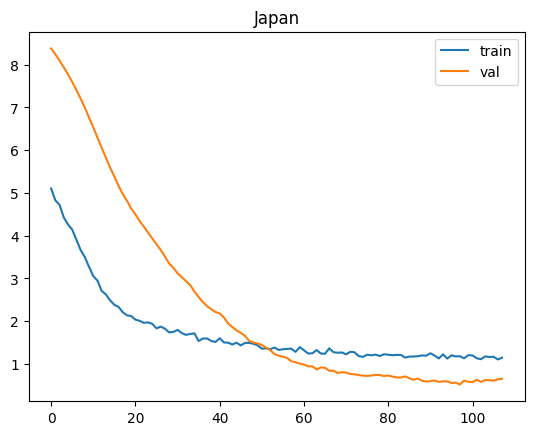

Korea (ROK)
Epoch 0: train loss 3.2923, val loss 5.0425, time 0.0917
Epoch 1: train loss 3.2657, val loss 4.9491, time 0.0789
Epoch 2: train loss 3.1896, val loss 4.8265, time 0.0788
Epoch 3: train loss 3.0592, val loss 4.6895, time 0.0800
Epoch 4: train loss 2.9889, val loss 4.5149, time 0.0787
Epoch 5: train loss 2.9299, val loss 4.2768, time 0.0786
Epoch 6: train loss 2.7374, val loss 3.9777, time 0.0806
Epoch 7: train loss 2.5442, val loss 3.5999, time 0.0789
Epoch 8: train loss 2.3558, val loss 3.1599, time 0.0793
Epoch 9: train loss 2.1749, val loss 2.7381, time 0.0791
Epoch 10: train loss 1.9651, val loss 2.3037, time 0.0778
Epoch 11: train loss 1.7390, val loss 1.9167, time 0.0778
Epoch 12: train loss 1.5240, val loss 1.5881, time 0.0797
Epoch 13: train loss 1.4483, val loss 1.3035, time 0.0788
Epoch 14: train loss 1.3649, val loss 1.0782, time 0.0782
Epoch 15: train loss 1.2887, val loss 0.9224, time 0.0797
Epoch 16: train loss 1.1959, val loss 0.7750, time 0.0790
Epoch 17: tr

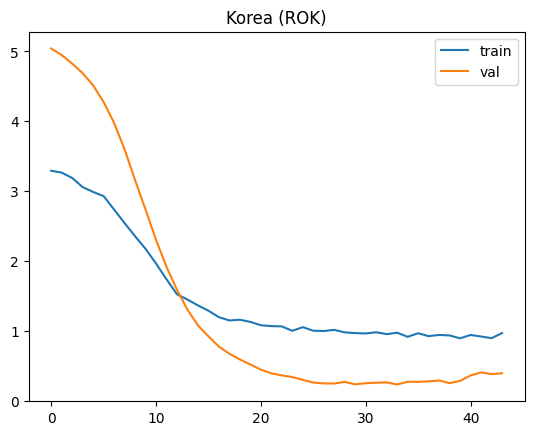

Macao, China
Epoch 0: train loss 2.0068, val loss 4.9102, time 0.0863
Epoch 1: train loss 2.0395, val loss 4.7434, time 0.0759
Epoch 2: train loss 1.9019, val loss 4.5796, time 0.0746
Epoch 3: train loss 1.7856, val loss 4.3900, time 0.0750
Epoch 4: train loss 1.6812, val loss 4.2088, time 0.0739
Epoch 5: train loss 1.6084, val loss 3.9971, time 0.0760
Epoch 6: train loss 1.5277, val loss 3.7594, time 0.0762
Epoch 7: train loss 1.5148, val loss 3.4836, time 0.0751
Epoch 8: train loss 1.3980, val loss 3.1887, time 0.0755
Epoch 9: train loss 1.3506, val loss 2.8798, time 0.0747
Epoch 10: train loss 1.3194, val loss 2.5744, time 0.0741
Epoch 11: train loss 1.1610, val loss 2.3188, time 0.0740
Epoch 12: train loss 1.0812, val loss 2.1126, time 0.0771
Epoch 13: train loss 1.0328, val loss 1.9348, time 0.0758
Epoch 14: train loss 0.9627, val loss 1.8079, time 0.0754
Epoch 15: train loss 0.9147, val loss 1.7108, time 0.0763
Epoch 16: train loss 0.9420, val loss 1.6071, time 0.0751
Epoch 17: t

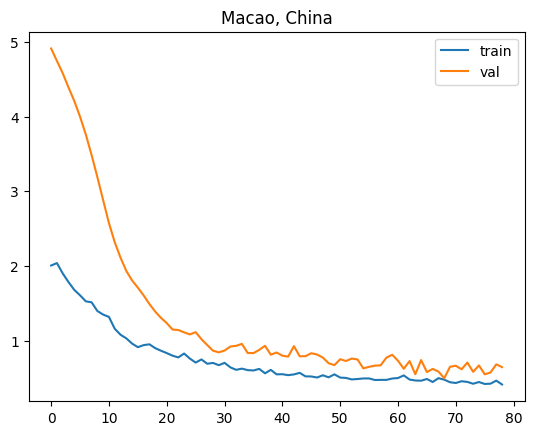

Maldives
Epoch 0: train loss 2.4380, val loss 3.5518, time 0.0899
Epoch 1: train loss 2.4068, val loss 3.3883, time 0.0784
Epoch 2: train loss 2.3421, val loss 3.1945, time 0.0780
Epoch 3: train loss 2.1807, val loss 2.9886, time 0.0779
Epoch 4: train loss 2.1362, val loss 2.7477, time 0.0787
Epoch 5: train loss 2.0862, val loss 2.4472, time 0.0786
Epoch 6: train loss 1.9835, val loss 2.1146, time 0.0796
Epoch 7: train loss 1.8210, val loss 1.7615, time 0.0784
Epoch 8: train loss 1.6801, val loss 1.4503, time 0.0782
Epoch 9: train loss 1.5280, val loss 1.1726, time 0.0787
Epoch 10: train loss 1.3462, val loss 1.0457, time 0.0793
Epoch 11: train loss 1.2036, val loss 1.0013, time 0.0796
Epoch 12: train loss 1.1359, val loss 0.9518, time 0.0797
Epoch 13: train loss 1.0542, val loss 0.9362, time 0.0784
Epoch 14: train loss 0.9718, val loss 0.8620, time 0.0786
Epoch 15: train loss 0.9240, val loss 0.7716, time 0.0789
Epoch 16: train loss 0.8687, val loss 0.6861, time 0.0789
Epoch 17: train

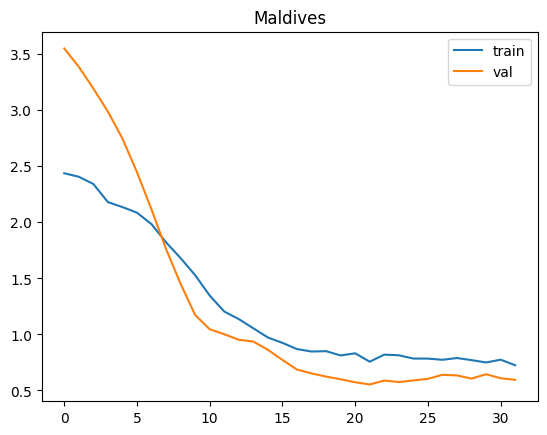

Cambodia
Epoch 0: train loss 3.0030, val loss 7.0664, time 0.0670
Epoch 1: train loss 3.0137, val loss 6.9490, time 0.0586
Epoch 2: train loss 2.9855, val loss 6.8354, time 0.0582
Epoch 3: train loss 2.9430, val loss 6.6898, time 0.0579
Epoch 4: train loss 2.7574, val loss 6.5401, time 0.0587
Epoch 5: train loss 2.7370, val loss 6.3669, time 0.0585
Epoch 6: train loss 2.6269, val loss 6.2025, time 0.0579
Epoch 7: train loss 2.6276, val loss 6.0064, time 0.0573
Epoch 8: train loss 2.5019, val loss 5.8140, time 0.0591
Epoch 9: train loss 2.3471, val loss 5.6101, time 0.0577
Epoch 10: train loss 2.2599, val loss 5.3792, time 0.0579
Epoch 11: train loss 2.1540, val loss 5.1160, time 0.0576
Epoch 12: train loss 2.0103, val loss 4.8306, time 0.0582
Epoch 13: train loss 1.9224, val loss 4.5478, time 0.0570
Epoch 14: train loss 1.6528, val loss 4.2536, time 0.0598
Epoch 15: train loss 1.5078, val loss 3.9735, time 0.0585
Epoch 16: train loss 1.3833, val loss 3.7132, time 0.0588
Epoch 17: train

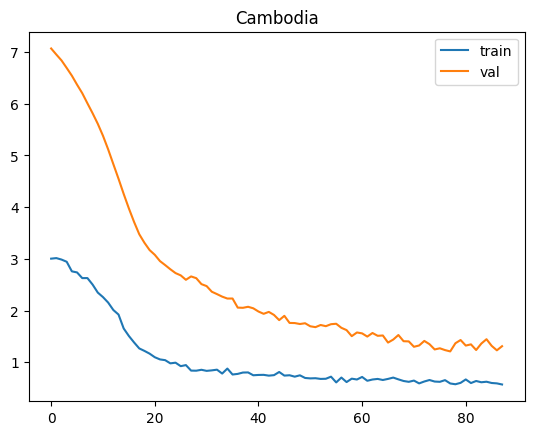

Indonesia
Epoch 0: train loss 1.3172, val loss 1.9886, time 0.0178
Epoch 1: train loss 1.2892, val loss 1.9627, time 0.0156
Epoch 2: train loss 1.3198, val loss 1.9394, time 0.0154
Epoch 3: train loss 1.2996, val loss 1.9189, time 0.0155
Epoch 4: train loss 1.2746, val loss 1.8950, time 0.0154
Epoch 5: train loss 1.2614, val loss 1.8723, time 0.0153
Epoch 6: train loss 1.2505, val loss 1.8484, time 0.0153
Epoch 7: train loss 1.2407, val loss 1.8252, time 0.0153
Epoch 8: train loss 1.2362, val loss 1.8027, time 0.0153
Epoch 9: train loss 1.2236, val loss 1.7789, time 0.0164
Epoch 10: train loss 1.2358, val loss 1.7598, time 0.0153
Epoch 11: train loss 1.1626, val loss 1.7347, time 0.0153
Epoch 12: train loss 1.1796, val loss 1.7133, time 0.0150
Epoch 13: train loss 1.1701, val loss 1.6898, time 0.0151
Epoch 14: train loss 1.1569, val loss 1.6730, time 0.0153
Epoch 15: train loss 1.1776, val loss 1.6531, time 0.0150
Epoch 16: train loss 1.1490, val loss 1.6325, time 0.0152
Epoch 17: trai

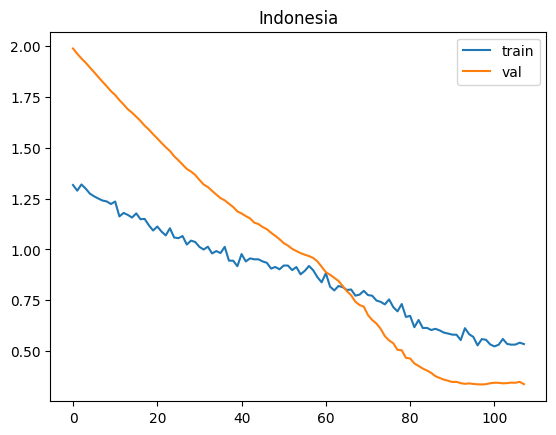

Singapore
Epoch 0: train loss 1.2708, val loss 3.4751, time 0.0692
Epoch 1: train loss 1.2328, val loss 3.4189, time 0.0600
Epoch 2: train loss 1.1972, val loss 3.3589, time 0.0614
Epoch 3: train loss 1.1902, val loss 3.2935, time 0.0627
Epoch 4: train loss 1.1630, val loss 3.2161, time 0.0624
Epoch 5: train loss 1.1465, val loss 3.1259, time 0.0607
Epoch 6: train loss 1.1035, val loss 3.0196, time 0.0609
Epoch 7: train loss 1.0704, val loss 2.9067, time 0.0617
Epoch 8: train loss 1.0197, val loss 2.7711, time 0.0622
Epoch 9: train loss 0.9957, val loss 2.6238, time 0.0622
Epoch 10: train loss 0.9743, val loss 2.4594, time 0.0618
Epoch 11: train loss 0.8858, val loss 2.2814, time 0.0617
Epoch 12: train loss 0.8767, val loss 2.1007, time 0.0633
Epoch 13: train loss 0.7970, val loss 1.9257, time 0.0610
Epoch 14: train loss 0.7854, val loss 1.7846, time 0.0605
Epoch 15: train loss 0.7199, val loss 1.6336, time 0.0607
Epoch 16: train loss 0.6908, val loss 1.5112, time 0.0609
Epoch 17: trai

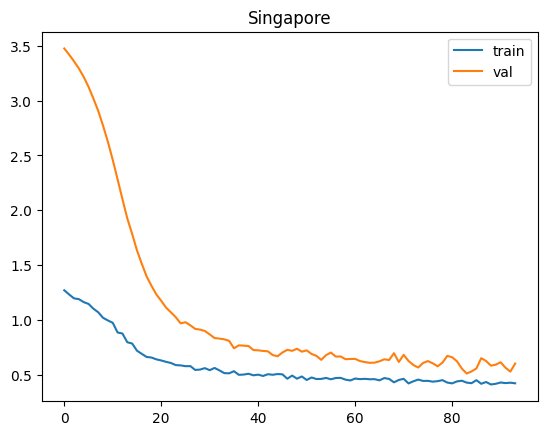

New Zealand
Epoch 0: train loss 1.9729, val loss 3.6810, time 0.0709
Epoch 1: train loss 1.9612, val loss 3.6231, time 0.0618
Epoch 2: train loss 1.9393, val loss 3.5663, time 0.0614
Epoch 3: train loss 1.8891, val loss 3.5018, time 0.0614
Epoch 4: train loss 1.8626, val loss 3.4306, time 0.0620
Epoch 5: train loss 1.7896, val loss 3.3508, time 0.0622
Epoch 6: train loss 1.7185, val loss 3.2638, time 0.0615
Epoch 7: train loss 1.6874, val loss 3.1615, time 0.0613
Epoch 8: train loss 1.6599, val loss 3.0316, time 0.0623
Epoch 9: train loss 1.6124, val loss 2.8999, time 0.0613
Epoch 10: train loss 1.5279, val loss 2.7468, time 0.0611
Epoch 11: train loss 1.4738, val loss 2.5758, time 0.0610
Epoch 12: train loss 1.3735, val loss 2.3719, time 0.0618
Epoch 13: train loss 1.3254, val loss 2.1560, time 0.0623
Epoch 14: train loss 1.2516, val loss 1.9702, time 0.0621
Epoch 15: train loss 1.1747, val loss 1.7943, time 0.0616
Epoch 16: train loss 1.1082, val loss 1.6209, time 0.0620
Epoch 17: tr

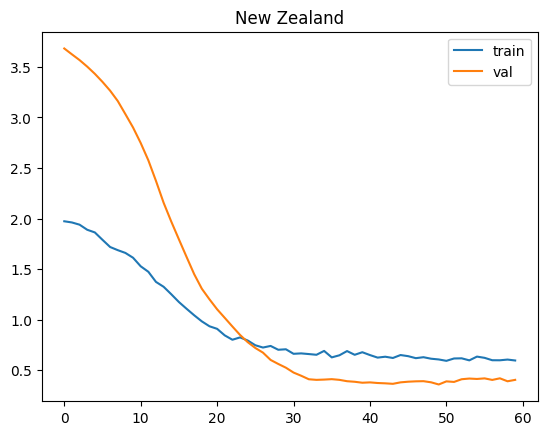

USA
Epoch 0: train loss 3.4764, val loss 5.5291, time 0.0814
Epoch 1: train loss 3.1965, val loss 5.4109, time 0.0717
Epoch 2: train loss 4.1796, val loss 5.2585, time 0.0701
Epoch 3: train loss 3.7997, val loss 5.0291, time 0.0712
Epoch 4: train loss 2.8516, val loss 4.8675, time 0.0704
Epoch 5: train loss 2.9600, val loss 4.6912, time 0.0702
Epoch 6: train loss 2.9712, val loss 4.4849, time 0.0811
Epoch 7: train loss 3.0597, val loss 4.2529, time 0.0710
Epoch 8: train loss 3.0678, val loss 4.0014, time 0.0720
Epoch 9: train loss 2.8150, val loss 3.8098, time 0.0724
Epoch 10: train loss 2.4701, val loss 3.6312, time 0.0703
Epoch 11: train loss 2.2715, val loss 3.4859, time 0.0705
Epoch 12: train loss 2.5731, val loss 3.2361, time 0.0709
Epoch 13: train loss 2.0338, val loss 3.0012, time 0.0717
Epoch 14: train loss 2.3966, val loss 2.7486, time 0.0701
Epoch 15: train loss 1.7471, val loss 2.5193, time 0.0737
Epoch 16: train loss 2.0303, val loss 2.2367, time 0.0710
Epoch 17: train loss

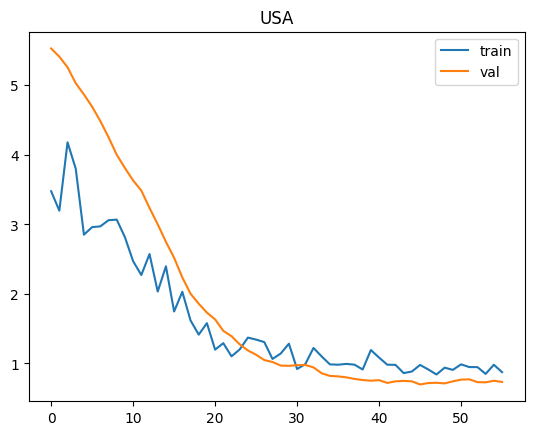

Thailand
Epoch 0: train loss 2.6169, val loss 5.8884, time 0.1051
Epoch 1: train loss 2.5529, val loss 5.8116, time 0.0920
Epoch 2: train loss 2.4810, val loss 5.7230, time 0.0921
Epoch 3: train loss 2.4284, val loss 5.6123, time 0.0929
Epoch 4: train loss 2.3368, val loss 5.4853, time 0.0900
Epoch 5: train loss 2.2686, val loss 5.3345, time 0.0903
Epoch 6: train loss 2.1909, val loss 5.1690, time 0.0898
Epoch 7: train loss 2.0979, val loss 4.9713, time 0.0891
Epoch 8: train loss 2.0055, val loss 4.7558, time 0.0878
Epoch 9: train loss 1.9344, val loss 4.5209, time 0.0904
Epoch 10: train loss 1.8326, val loss 4.2636, time 0.0906
Epoch 11: train loss 1.7278, val loss 3.9920, time 0.0893
Epoch 12: train loss 1.6305, val loss 3.7113, time 0.0909
Epoch 13: train loss 1.5379, val loss 3.4217, time 0.0896
Epoch 14: train loss 1.4259, val loss 3.1458, time 0.0896
Epoch 15: train loss 1.3888, val loss 2.9013, time 0.0895
Epoch 16: train loss 1.3078, val loss 2.6761, time 0.0904
Epoch 17: train

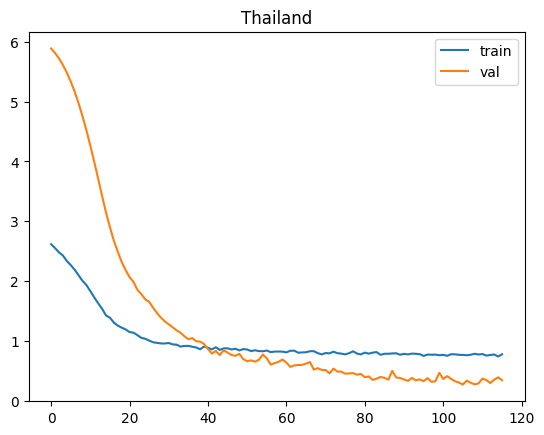

Turkey
Epoch 0: train loss 2.3102, val loss 6.0389, time 0.0871
Epoch 1: train loss 2.2181, val loss 5.9373, time 0.0768
Epoch 2: train loss 2.0382, val loss 5.8424, time 0.0773
Epoch 3: train loss 2.1739, val loss 5.7327, time 0.0760
Epoch 4: train loss 1.9828, val loss 5.6243, time 0.0750
Epoch 5: train loss 2.0030, val loss 5.5098, time 0.0753
Epoch 6: train loss 1.9874, val loss 5.3794, time 0.0745
Epoch 7: train loss 1.8068, val loss 5.2242, time 0.0728
Epoch 8: train loss 1.8824, val loss 5.0467, time 0.0729
Epoch 9: train loss 1.7875, val loss 4.8326, time 0.0731
Epoch 10: train loss 1.7424, val loss 4.5975, time 0.0724
Epoch 11: train loss 1.6708, val loss 4.3608, time 0.0725
Epoch 12: train loss 1.5630, val loss 4.1045, time 0.0757
Epoch 13: train loss 1.4950, val loss 3.8542, time 0.0755
Epoch 14: train loss 1.3042, val loss 3.6508, time 0.0739
Epoch 15: train loss 1.2804, val loss 3.4035, time 0.0741
Epoch 16: train loss 1.2592, val loss 3.1636, time 0.0733
Epoch 17: train l

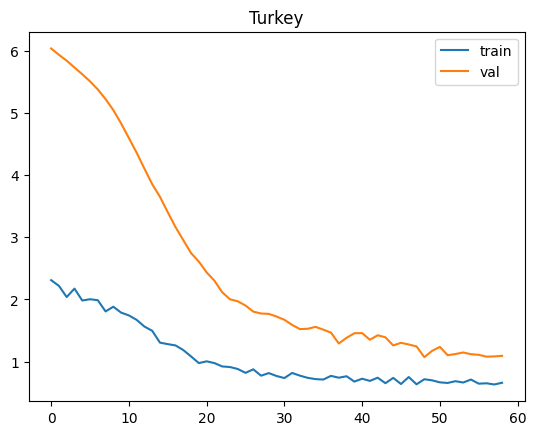

Australia
Epoch 0: train loss 3.8145, val loss 8.6242, time 0.1333
Epoch 1: train loss 3.5487, val loss 8.1939, time 0.1184
Epoch 2: train loss 3.4936, val loss 7.6274, time 0.1220
Epoch 3: train loss 3.3319, val loss 6.9115, time 0.1281
Epoch 4: train loss 3.0591, val loss 6.1161, time 0.1184
Epoch 5: train loss 2.6678, val loss 5.2061, time 0.1155
Epoch 6: train loss 2.3720, val loss 4.2270, time 0.1192
Epoch 7: train loss 1.9175, val loss 3.4981, time 0.1166
Epoch 8: train loss 1.8811, val loss 2.9875, time 0.1176
Epoch 9: train loss 1.7765, val loss 2.5050, time 0.1170
Epoch 10: train loss 1.6184, val loss 2.1804, time 0.1193
Epoch 11: train loss 1.4206, val loss 2.0786, time 0.1184
Epoch 12: train loss 1.2864, val loss 1.8373, time 0.1185
Epoch 13: train loss 1.3890, val loss 1.7326, time 0.1179
Epoch 14: train loss 1.2524, val loss 1.5822, time 0.1193
Epoch 15: train loss 1.2090, val loss 1.4688, time 0.1183
Epoch 16: train loss 1.1733, val loss 1.4122, time 0.1172
Epoch 17: trai

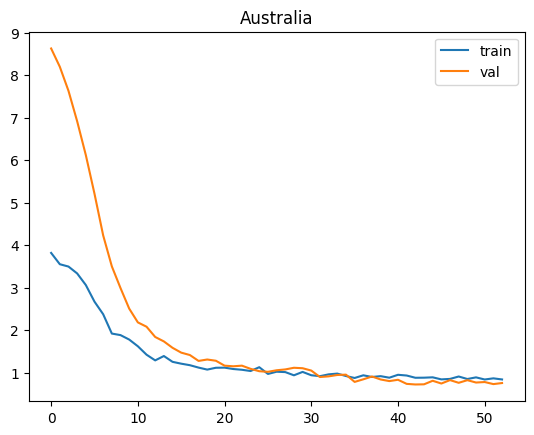

Hawaii
Epoch 0: train loss 2.1804, val loss 2.6222, time 0.7887
Epoch 1: train loss 2.1617, val loss 2.5275, time 0.0797
Epoch 2: train loss 2.0817, val loss 2.4121, time 0.0789
Epoch 3: train loss 1.9849, val loss 2.2794, time 0.0812
Epoch 4: train loss 1.9437, val loss 2.1136, time 0.0798
Epoch 5: train loss 1.8603, val loss 1.9102, time 0.0795
Epoch 6: train loss 1.7538, val loss 1.7541, time 0.0800
Epoch 7: train loss 1.6406, val loss 1.6031, time 0.0805
Epoch 8: train loss 1.5571, val loss 1.4181, time 0.0806
Epoch 9: train loss 1.4444, val loss 1.2086, time 0.0812
Epoch 10: train loss 1.2623, val loss 1.0791, time 0.0802
Epoch 11: train loss 1.2279, val loss 1.1185, time 0.0797
Epoch 12: train loss 1.1387, val loss 1.1926, time 0.0790
Epoch 13: train loss 1.0738, val loss 1.2342, time 0.0783
Epoch 14: train loss 1.0560, val loss 1.2120, time 0.0801
Epoch 15: train loss 1.0350, val loss 1.1947, time 0.0807
Epoch 16: train loss 0.9713, val loss 1.2021, time 0.0801
Epoch 17: train l

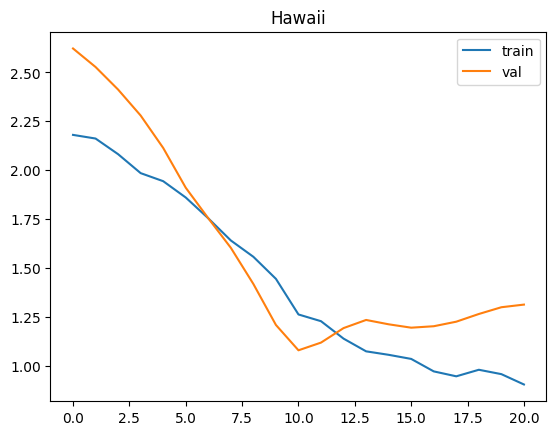

Austria
Epoch 0: train loss 2.5165, val loss 5.5839, time 0.0666
Epoch 1: train loss 2.5334, val loss 5.5020, time 0.0568
Epoch 2: train loss 2.3980, val loss 5.4160, time 0.0554
Epoch 3: train loss 2.4194, val loss 5.3142, time 0.0558
Epoch 4: train loss 2.3992, val loss 5.1953, time 0.0569
Epoch 5: train loss 2.2776, val loss 5.0622, time 0.0638
Epoch 6: train loss 2.2672, val loss 4.9035, time 0.0575
Epoch 7: train loss 2.2122, val loss 4.7047, time 0.0569
Epoch 8: train loss 2.0511, val loss 4.4744, time 0.0584
Epoch 9: train loss 1.9323, val loss 4.2200, time 0.0574
Epoch 10: train loss 1.8764, val loss 3.9200, time 0.0574
Epoch 11: train loss 1.6655, val loss 3.5914, time 0.0579
Epoch 12: train loss 1.5055, val loss 3.2582, time 0.0583
Epoch 13: train loss 1.4004, val loss 2.9341, time 0.0571
Epoch 14: train loss 1.3024, val loss 2.6412, time 0.0572
Epoch 15: train loss 1.1260, val loss 2.4407, time 0.0566
Epoch 16: train loss 1.1253, val loss 2.2276, time 0.0587
Epoch 17: train 

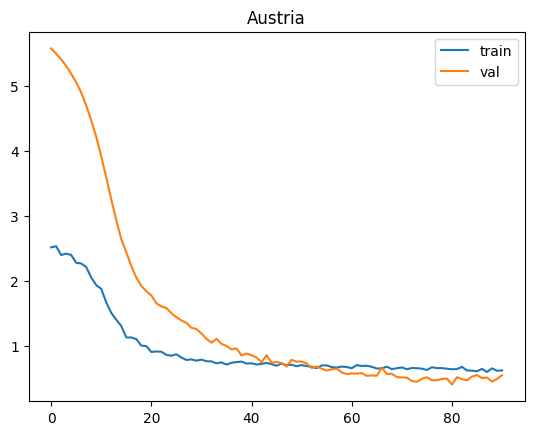

Czech
Epoch 0: train loss 1.6334, val loss 3.2965, time 0.0228
Epoch 1: train loss 1.6160, val loss 3.2723, time 0.0198
Epoch 2: train loss 1.5966, val loss 3.2514, time 0.0196
Epoch 3: train loss 1.5587, val loss 3.2306, time 0.0195
Epoch 4: train loss 1.5689, val loss 3.2080, time 0.0193
Epoch 5: train loss 1.5621, val loss 3.1851, time 0.0192
Epoch 6: train loss 1.5587, val loss 3.1649, time 0.0204
Epoch 7: train loss 1.5254, val loss 3.1411, time 0.0190
Epoch 8: train loss 1.5246, val loss 3.1164, time 0.0190
Epoch 9: train loss 1.5203, val loss 3.0910, time 0.0191
Epoch 10: train loss 1.5015, val loss 3.0657, time 0.0188
Epoch 11: train loss 1.4843, val loss 3.0381, time 0.0189
Epoch 12: train loss 1.4830, val loss 3.0124, time 0.0186
Epoch 13: train loss 1.4544, val loss 2.9861, time 0.0190
Epoch 14: train loss 1.4350, val loss 2.9558, time 0.0187
Epoch 15: train loss 1.4334, val loss 2.9262, time 0.0190
Epoch 16: train loss 1.4184, val loss 2.8965, time 0.0187
Epoch 17: train lo

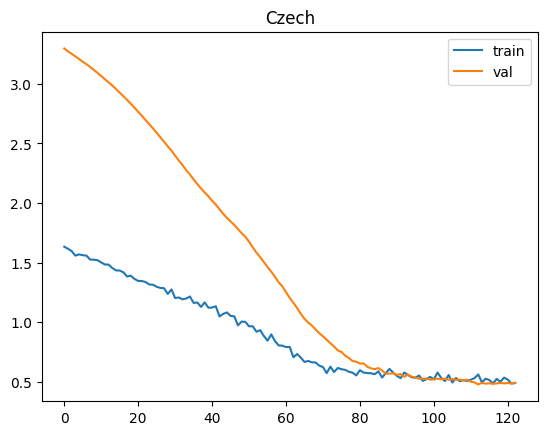

In [190]:
best_param = ({'seq_len': 24, 'batch_size': 64}, 
              {'model_type': 'gru', 'num_layers': 1, 'hidden_size': 20}, 
              {'optim_type': 'nadam', 'lr': 0.001})

rnn_sep_pred, rnn_sep_gt = [], []
rnn_sep_sample = [[] for _ in range(100)]
for i, country in enumerate(country_list):
    print(country)
    seq_train_x, seq_train_y, train_mase, seq_test_x, seq_test_y, test_mase = sliding_window(all_data[country], input_len=best_param[0]['seq_len'], 
                                                                      output_len=12, test_size=1)

    model = ForecastModel(**best_param[1], input_size=18, output_size=12, conditional_labels=country_list)
    optimizer = get_torch_optimizer(best_param[2]['optim_type'], model.parameters(), lr=best_param[2]['lr'])
    criterion = get_torch_criterion('mase')

    train_dataset = TimeSeriesDataset(seq_train_x, seq_train_y, mases=train_mase)# (model.num_layers, model.hidden_size))
    test_dataset = TimeSeriesDataset(seq_test_x, seq_test_y, mases=test_mase)# (model.num_layers, model.hidden_size))
    train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=best_param[0]['batch_size'], pin_memory=True)
    test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1, pin_memory=True)

    model, train_losses, val_losses = train_rnn(model, criterion, optimizer, train_dataloader, test_dataloader, early_stop_patience=10, cuda=True, epochs=150, mase=True)
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.title(country)
    plt.legend()
    plt.show()
    
    rnn_preds, _ = eval_rnn(model, criterion, test_dataloader, mase=True)

    _, ds_x, ds_y, _ = test_dataset.__getitem__(0)
    rnn_sep_pred.append(inverse_target(rnn_preds[0], all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                   y_scaler if single_y_scaler else y_scaler[country]))
    rnn_sep_gt.append(inverse_target(ds_y, all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                                 y_scaler if single_y_scaler else y_scaler[country]))
    for j in range(100):
        rnn_preds, _ = eval_rnn(model, criterion, test_dataloader, dropout=True, mase=True)
        rnn_sep_sample[j].append(inverse_target(rnn_preds[0], all_decomposed_seasonal[country].seasonal.loc[all_test_y[i].index - pd.DateOffset(years=4)].values if deduct_seasonality else 0.,
                               y_scaler if single_y_scaler else y_scaler[country]))
rnn_sep_gt = np.concatenate(rnn_sep_gt)
rnn_sep_pred = np.concatenate(rnn_sep_pred)
for j in range(100):
    rnn_sep_sample[j] = np.concatenate(rnn_sep_sample[j])
rnn_sep_sample = np.asarray(rnn_sep_sample)

In [191]:
ci = get_confidence_interval(rnn_sep_sample)
rnn_sep_lower = rnn_sep_pred - ci
rnn_sep_upper = rnn_sep_pred + ci

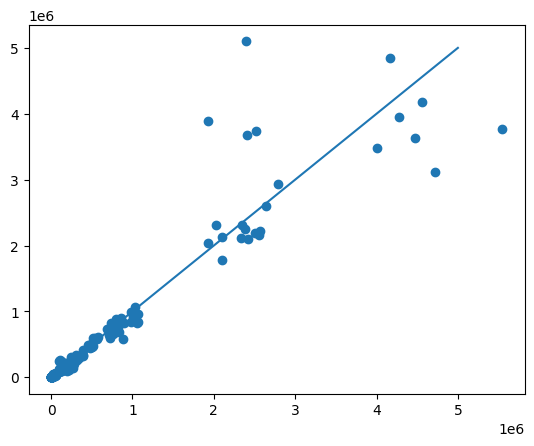

In [192]:
plt.scatter(all_y, rnn_sep_pred)
plt.plot((0, 5000000), (0, 5000000))

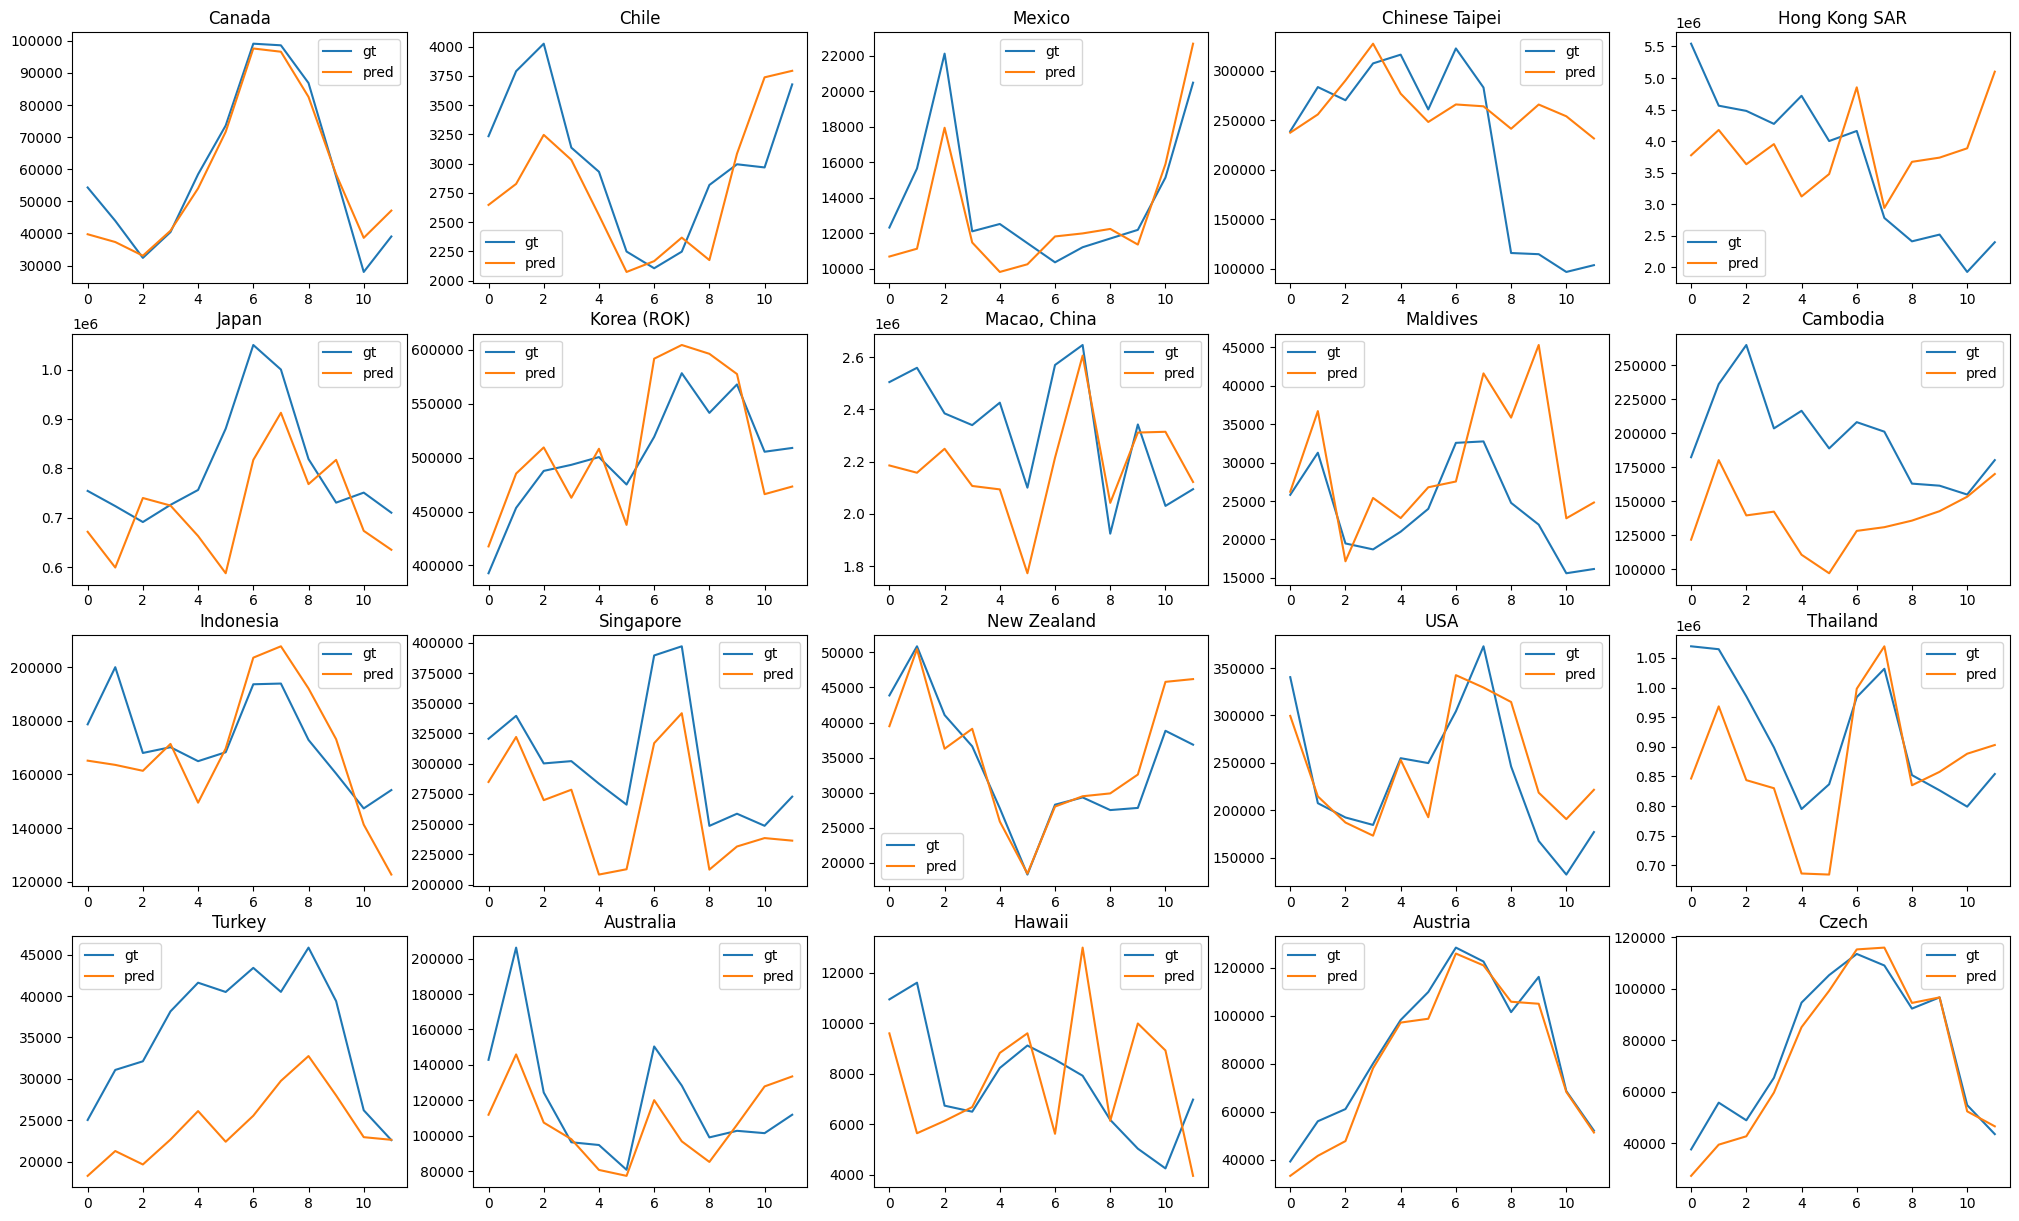

In [193]:
plt.figure(figsize=(25, 15))
for i, country in enumerate(country_list):
    plt.subplot(4, 5, i+1)
    plt.plot(all_y[i*12:i*12+12], label='gt')
    plt.plot(rnn_sep_pred[i*12:i*12+12], label='pred')
    plt.legend()
    plt.title(country)
plt.show()

In [203]:
rnn_sep_rmse = sqrt(mean_squared_error(all_y, rnn_sep_pred))
rnn_sep_r2 = r2_score(all_y, rnn_sep_pred)
rnn_sep_mae = mean_absolute_error(all_y, rnn_sep_pred)
rnn_sep_mape = mean_absolute_percentage_error(all_y, rnn_sep_pred)
rnn_sep_mase = mean_absolute_scaled_error(all_y, rnn_sep_pred, y_mase_scales)
rnn_sep_winkler = winkler_score(rnn_sep_lower, rnn_sep_upper, all_y)
print(f'RNN Sep RMSE: {rnn_sep_rmse:.5f}\nRNN Sep R2: {rnn_sep_r2:.5f}\nRNN Sep MAE: {rnn_sep_mae:.5f}'
      f'\nRNN Sep MAPE: {rnn_sep_mape:.5f}\nRNN Sep MASE: {rnn_sep_mase:.5f}\nRNN Sep Winkler: {rnn_sep_winkler:.5f}')

RNN Sep RMSE: 309187.70611
RNN Sep R2: 0.88961
RNN Sep MAE: 91660.17642
RNN Sep MAPE: 0.18302
RNN Sep MASE: 2.04537
RNN Sep Winkler: 793690.10242


# Ensemble RNN models

In [199]:
for w in range(10):
    w = w / 10
    ensemble_pred = w * rnn_sep_pred + (1 - w) * rnn_os_pred
    ens_rmse = sqrt(mean_squared_error(all_y, ensemble_pred))
    print(f'Weight: {w}, RMSE: {ens_rmse:.5f}')
w = 0.4
ensemble_pred = w * rnn_sep_pred + (1 - w) * rnn_os_pred
ensemble_sample = w * rnn_sep_sample + (1 - w) * rnn_os_sample

Weight: 0.0, RMSE: 256730.61097
Weight: 0.1, RMSE: 253488.21486
Weight: 0.2, RMSE: 252248.43158
Weight: 0.3, RMSE: 253040.69850
Weight: 0.4, RMSE: 255846.13863
Weight: 0.5, RMSE: 260599.74271
Weight: 0.6, RMSE: 267197.55398
Weight: 0.7, RMSE: 275507.10970
Weight: 0.8, RMSE: 285378.92325
Weight: 0.9, RMSE: 296657.07454


In [197]:
ci = get_confidence_interval(ensemble_sample)
ensemble_lower = ensemble_pred - ci
ensemble_upper = ensemble_pred + ci

In [206]:
rnn_ens_rmse = sqrt(mean_squared_error(all_y, ensemble_pred))
rnn_ens_r2 = r2_score(all_y, ensemble_pred)
rnn_ens_mae = mean_absolute_error(all_y, ensemble_pred)
rnn_ens_mape = mean_absolute_percentage_error(all_y, ensemble_pred)
rnn_ens_mase = mean_absolute_scaled_error(all_y, ensemble_pred, y_mase_scales)
rnn_ens_winkler = winkler_score(ensemble_lower, ensemble_upper, all_y)

print(f'RNN Ensemble RMSE: {rnn_ens_rmse:.5f}\nRNN Ensemble R2: {rnn_ens_r2:.5f}\nRNN Ensemble MAE: {rnn_ens_mae:.5f}'
      f'\nRNN Ensemble MAPE: {rnn_ens_mape:.5f}\nRNN Ensemble MASE: {rnn_ens_mase:.5f}\nRNN Ensemble Winkler: {rnn_ens_winkler:.5f}')

RNN Ensemble RMSE: 255846.13863
RNN Ensemble R2: 0.92441
RNN Ensemble MAE: 79243.04230
RNN Ensemble MAPE: 0.16884
RNN Ensemble MASE: 1.78082
RNN Ensemble Winkler: 709992.87064


In [ ]:
# swap green to RNNe
temp = plt.rcParams['axes.prop_cycle'].by_key()['color']
temp[2], temp[5] = temp[5], temp[2]

In [ ]:
fig = plt.figure(figsize=(25, 15))
for i, country in enumerate(country_list):
    plt.subplot(4, 5, i+1)
    plt.plot(all_y[i*12:i*12+12], label='Actual', color=temp[0])
    plt.plot(sarima_pred[i*12:i*12+12], label='SARIMA', color=temp[1])
    plt.plot(reg_comb_pred[i*12:i*12+12], label='DT', color=temp[2])
    plt.plot(rnn_sep_pred[i*12:i*12+12], label='RNN$_1$', color=temp[3])
    plt.plot(rnn_os_pred[i*12:i*12+12], label='RNN$_H$', color=temp[4])
    plt.plot(ensemble_pred[i*12:i*12+12], label='RNN$_e$', color=temp[5])
    # plt.legend()
    plt.title(country, fontsize=15)

handles, labels = plt.gca().get_legend_handles_labels()
leg = fig.legend(handles, labels, fontsize=15, loc='lower center', ncol=6, bbox_to_anchor=(0.5, 0.05))
for legobj in leg.legend_handles:
    legobj.set_linewidth(3.0)
plt.show()